# Laboratorio 1 BI
* Karen Fuentes
* Marco Ramirez
* Jenifer Arce

# 0. Carga de datos
## 0.1. Funciones para colab

In [ ]:
import os
def list_files_in_current_directory():
    return [f for f in os.listdir('.') if os.path.isfile(f)]
def get_current_folder_name():
    return os.path.basename(os.getcwd())

print("we're currently in:",get_current_folder_name())

print(f"There are {len(list_files_in_current_directory())} file(s) in the folder")
if len(list_files_in_current_directory()) < 2:
  raise Exception("There are not enough files in the folder, please upload the base data into de folder")

we're currently in: content
There are 4 file(s) in the folder


## 0.2. Importe de archivos

In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

## 0.3. Upload de archivos

In [ ]:
def getTrainingData():
  filesInFolder = list_files_in_current_directory()
  for x in filesInFolder:
    if 'train_data' in x:
      return pd.read_csv(x)
  raise Exception("No training data found in the folder")

def gestTestData():
  filesInFolder = list_files_in_current_directory()
  for x in filesInFolder:
    if 'validation_data' in x:
      return pd.read_csv(x)
  raise Exception("No validation data found in the folder")

trainData = getTrainingData()
testData = gestTestData()

# 1. PARTE 1-> Entendimiento de datos - Perfilamiento de datos
## Variable a encontrar: redshift

In [ ]:
# columnsTraining = getTrainingData().columns
# columnsTesting = gestTestData().columns
trainData.columns

# print('the column to find is:',list(set(columnsTraining) - set(columnsTesting))[0])

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field',
       'score', 'clean', 'class', 'redshift', 'mjd', 'rowv', 'colv'],
      dtype='object')

## Diccionario
Vamos a poner el diccionario de datos aquí para tenerlo a la mano

| Atributo | Descripción                                                                                                                              |
| -------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| ra       | Ubicación del objeto en su componente de ascensión recta de coordenada celeste.                                                          |
| dec      | Ubicación del objeto en su componente de declinación de coordenada celeste.                                                              |
| u        | Magnitud del objeto capturada en el filtro ultravioleta. Valor mayor a 0.                                                                |
| g        | Magnitud del objeto capturada en el filtro verde. Valor mayor a 0.                                                                       |
| r        | Magnitud del objeto capturada en el filtro rojo. Valor mayor a 0.                                                                        |
| z        | Magnitud del objeto capturada en el filtro casi-infrarrojo. Valor mayor a 0.                                                             |
| i        | Magnitud del objeto capturada en el filtro infrarrojo. Valor mayor a 0.                                                                  |
| run      | Número de observación realizada por el telescopio.                                                                                       |
| camcol   | Columna de la cámara en la que se registró el objeto.                                                                                    |
| field    | Sección de la columna de la cámara en la que se registró el objeto.                                                                      |
| score    | Valor de calidad de la observación en la sección de la columna (field). Es un número entre 0 y 1.                                        |
| clean    | Flag que indica si la fotometría del objeto es confiable. (1) si lo es (0) en caso de que se sospeche irregularidades con la fotometría. |
| class    | Tipo de objeto registrado: Estrella (STAR) o Galaxia (GALAXY) o Cuasar (QSO)                                                             |
| redshift | Valor de corrimiento al rojo obtenido del objeto calculado por espectroscopía.                                                           |
| mjd      | Día juliano en que se registró el objeto.                                                                                                |
| rowv     | Velocidad horizontal (fila) del objeto en grados/día.                                                                                    |
| colv     | Velocidad vertical (columna) del objeto en grados/columna.                                                                               |

Con describe podemos ver las variables que hay y unas primeras estadísticas para conocer como están los datos

In [ ]:
print(trainData.shape)
trainData.describe()


(4000, 18)


,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,redshift,mjd,rowv,colv
count,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1.237649e+18,185.523295,0.248959,18.609049,17.363397,16.839856,16.597712,16.439392,743.829000,3.37625,419.602000,0.851765,0.895500,0.134015,52957.124750,0.000218,-0.000090
std,4.244222e+11,41.689446,2.001075,0.839431,0.950964,1.055343,1.141252,1.190502,98.865936,1.69909,167.162063,0.071311,0.305946,0.379742,1601.148131,0.008794,0.007457
min,1.237646e+18,10.469743,-1.252763,13.551780,12.974870,12.362850,12.010790,11.799530,211.000000,1.00000,19.000000,0.301912,0.000000,-0.003322,51608.000000,-0.264516,-0.168807
25%,1.237649e+18,162.474666,-0.631824,18.170375,16.796110,16.190785,15.870782,15.628205,752.000000,2.00000,311.000000,0.836866,1.000000,0.000106,51821.000000,-0.001212,-0.001609
50%,1.237649e+18,195.815451,0.053336,18.843745,17.472525,16.850835,16.571195,16.402665,756.000000,3.00000,434.000000,0.860675,1.000000,0.032038,51986.000000,0.000322,0.000125
75%,1.237649e+18,214.348425,0.593396,19.261563,17.997818,17.506640,17.258833,17.147037,756.000000,5.00000,527.000000,0.879834,1.000000,0.086479,54468.000000,0.001698,0.001672
max,1.237650e+18,249.758313,13.854010,19.599750,22.497450,22.265960,28.179630,20.847690,1035.000000,6.00000,812.000000,0.961145,1.000000,4.192597,58932.000000,0.181871,0.128814


:* Las variables u, g, r, z, i -> son magnitudes, todas ellas van de desde un minimo de 11 (aprox) hasta 28 máximo
* Hay 6 columnas de cámaras
* La velocidad vertical y horizontal van hasta máximo 0.18 grados/dia para rowv y 0.12 grados/columna para colv
* Las velocidades (rowv, colv) tienen una media cercana a 0, lo que indica que la mayoría de los objetos no tienen tanto movimiento.
* La mayoría de las observaciones tienen un clean = 1.0, lo que indica que la mayoría de los datos son confiables.
* El score promedio es de 0.85, lo que sugiere que las observaciones son en general de alta calidad.

# 3. PARTE 1-> Entendimiento de datos - Calidad de los datos
## Completitud training

In [ ]:
((trainData.isnull().sum()/trainData.shape[0])).sort_values(ascending=False)

,0
objid,0.0
ra,0.0
rowv,0.0
mjd,0.0
redshift,0.0
class,0.0
clean,0.0
score,0.0
field,0.0
camcol,0.0


Los datos del training están bien

## Unicidad training

In [ ]:
# trainData = getTrainingData()
# testData = gestTestData()
print(trainData.shape)
trainData = trainData.drop_duplicates(subset='objid', keep='first')
trainData = trainData.drop_duplicates(keep='first')
print(trainData.shape)
print('Ya eliminamos 17 registros que eran iguales, o tenían ID igual')

(4000, 18)
(3983, 18)
Ya eliminamos 17 registros que eran iguales, o tenían ID igual


## Consistencia

In [ ]:
trainData["class"].value_counts()

,count
class,
GALAXY,1847
STAR,1625
QSO,291
S,175
G,44
QUASAR,1


Observamos un problema de consistencia, debido a que S representa Star, G representa Galaxy y  QSO es Quasar

In [ ]:
trainData["class"] = trainData["class"].replace("QUASAR", "QSO")
trainData["class"] = trainData["class"].replace("S", "STAR")
trainData["class"] = trainData["class"].replace("G", "GALAXY")

In [ ]:
trainData["class"].value_counts()

,count
class,
GALAXY,1891
STAR,1800
QSO,292


In [ ]:
trainData["run"].value_counts() # puede ser categorica?
trainData["clean"].value_counts() # es categorica, 1 o 0
trainData["camcol"].value_counts() # Xategorica -> Columna de la cámara en la que se registró el objeto.

,count
camcol,
1,797
4,749
5,714
2,629
3,580
6,514


## Validez:
# No habían columnas para analizar validez.

# 4. PARTE 1-> Entendimiento de datos - gráficas
## Dispersiones - scatter
Empezamos a analizar las columnas. Vamos analizar como están con respecto a su dispersión.

Las columnas que utilizaremos serán: 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field','score', 'clean', 'redshift', 'mjd', 'rowv', 'colv'

16


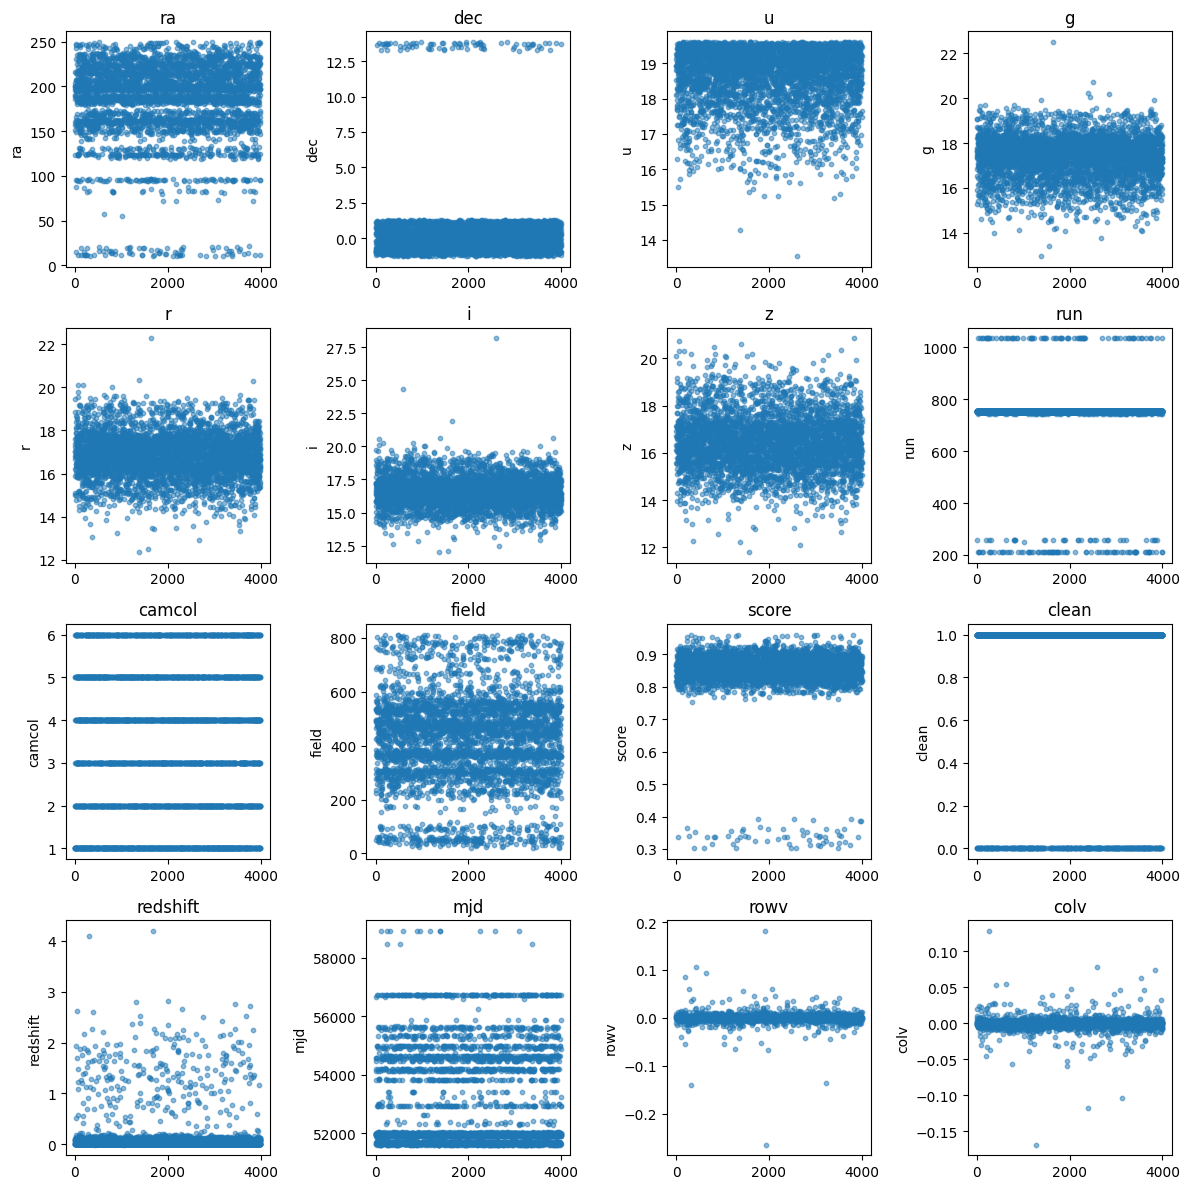

In [ ]:
vars_to_plot = [ 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field','score', 'clean', 'redshift', 'mjd', 'rowv', 'colv']
print(len(vars_to_plot))
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    axes[i].scatter(trainData.index, trainData[var], alpha=0.5, s=10)
    axes[i].set_title(var)
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()
#scatter_matrix(baseData[vars_to_plot], figsize=(10, 10), alpha=0.5, diagonal="kde")



Insights de la dispersión:
* Se destaca que redshift tiene algunos valores atípicos extremadamente altos (>4)
* La variable score también tiene algunos valores atípicos bajos (<0.4)
* La variable dec muestra dos concentraciones diferentes en 2 bandas, esto puede ser debido a un sesgo en el proceso de toma de datos
* Hay una cantidad importante de datos con valores clean en 0
* Las variables rowv y colv tienen concentraciones cercanas a 0 pero hay algunos datos extremos de objetos transitorios.

## Ahora vamos a realizar Boxplots e histogramas

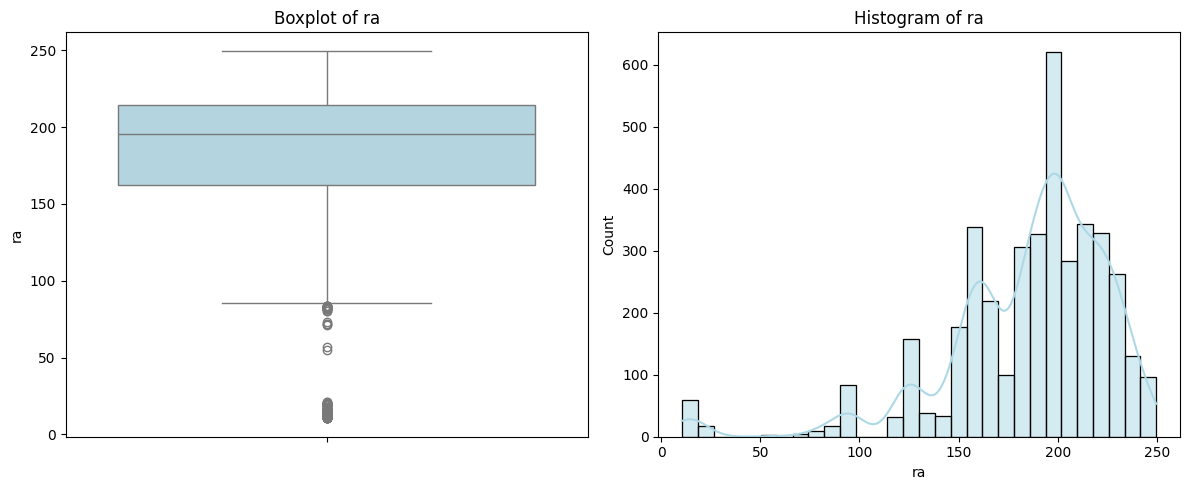

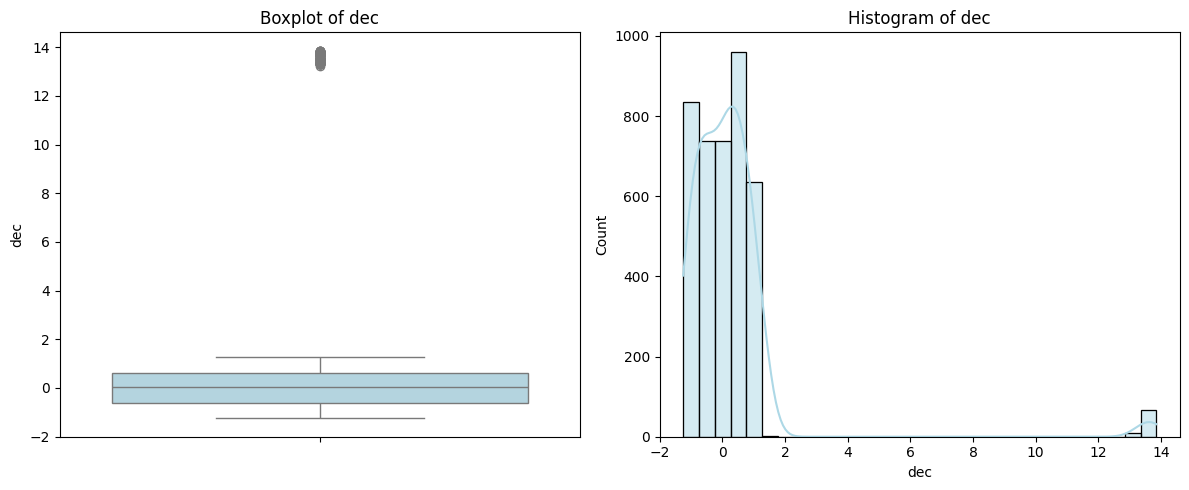

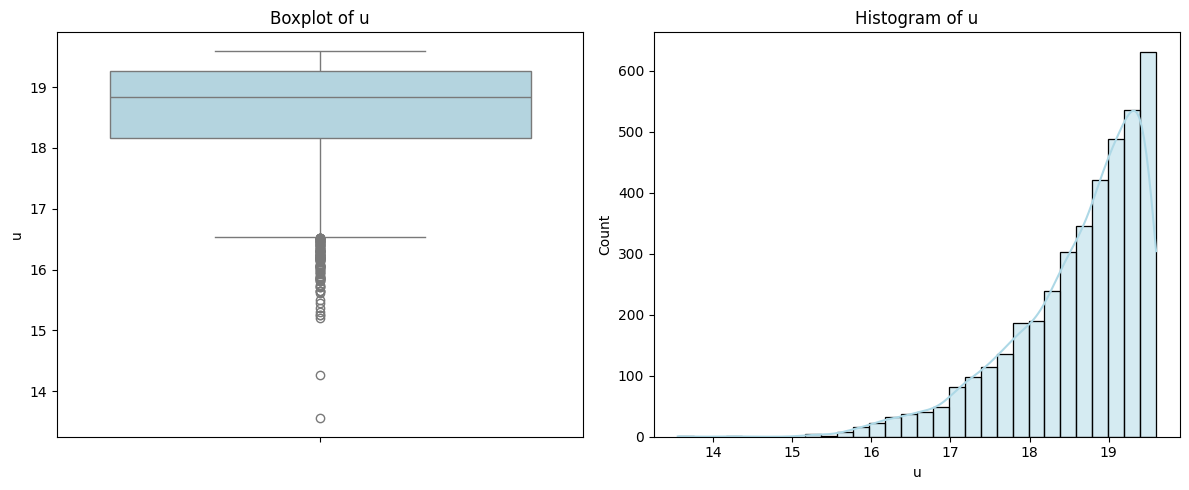

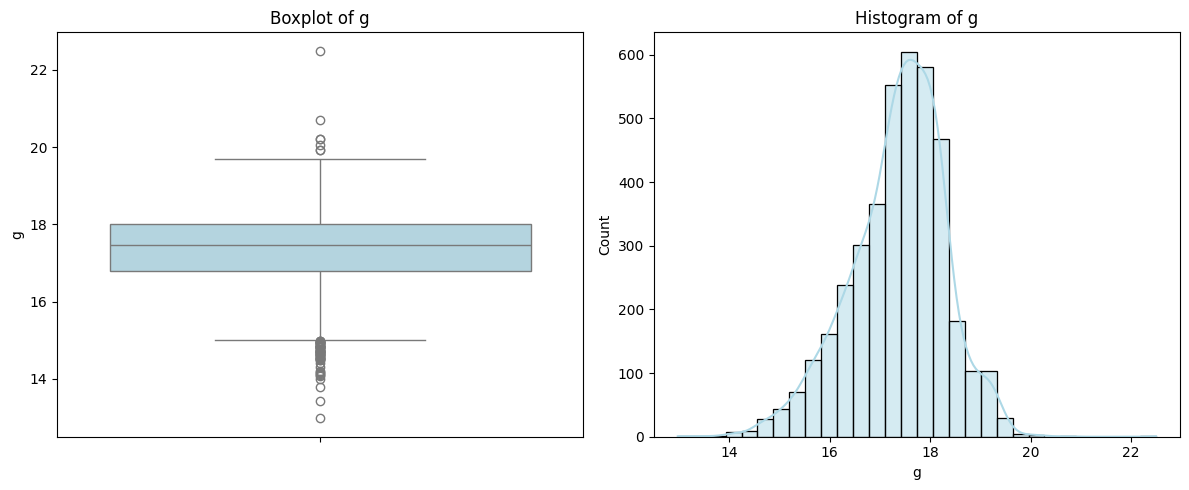

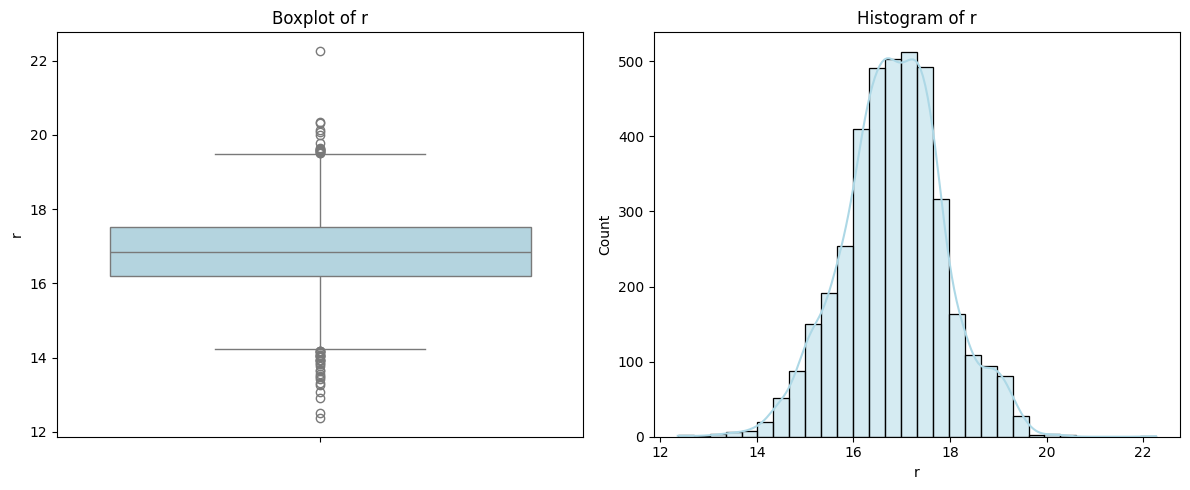

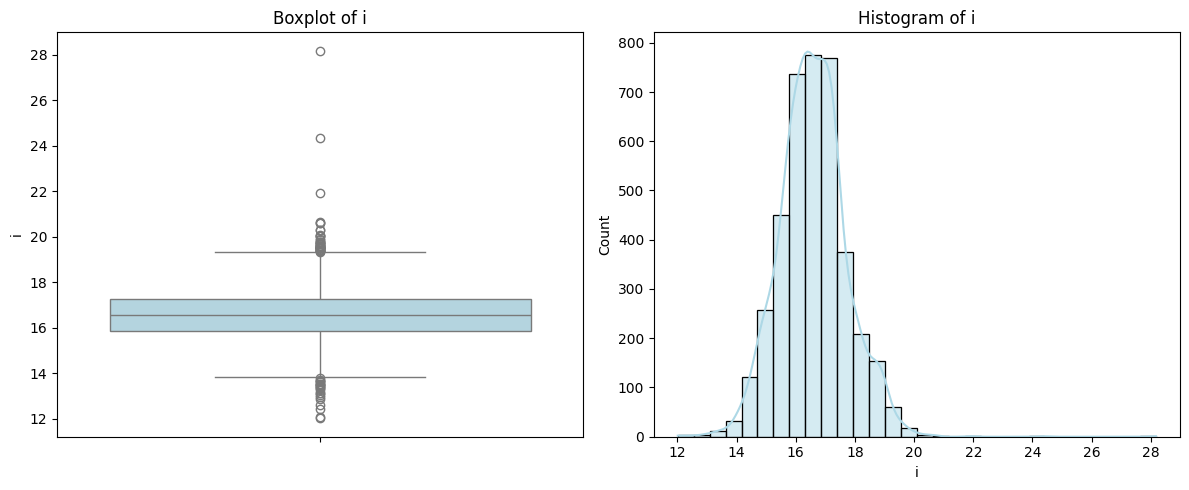

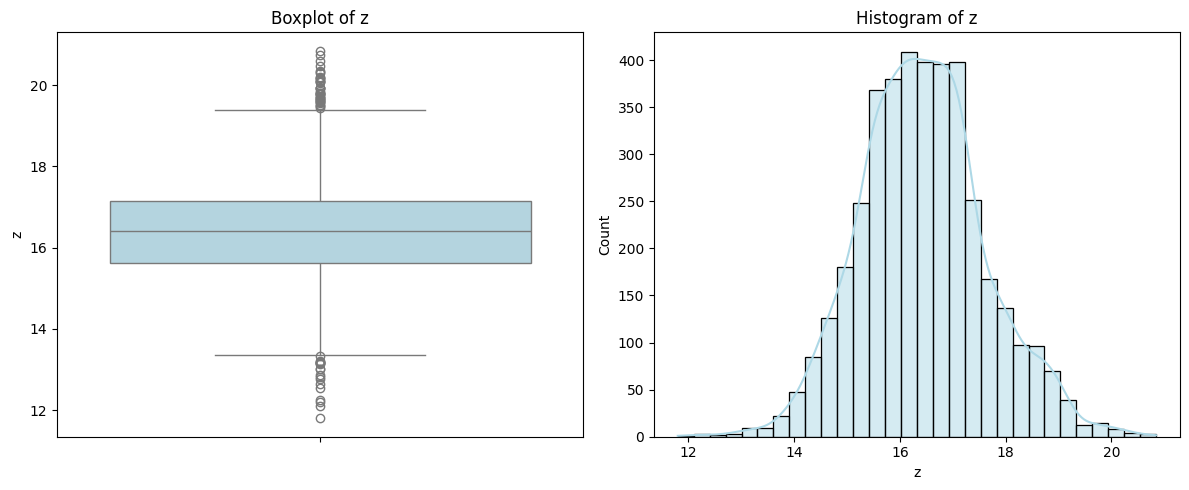

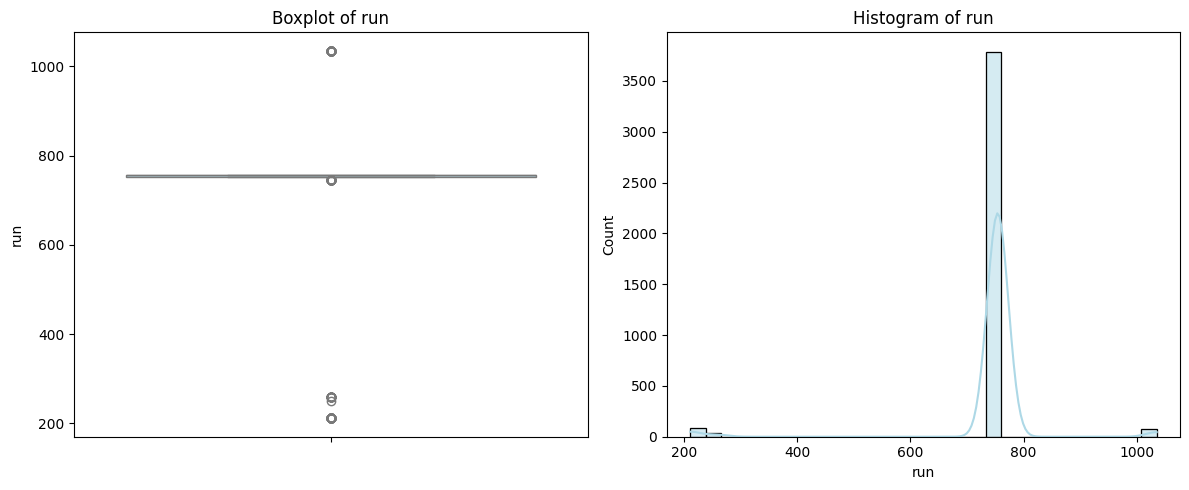

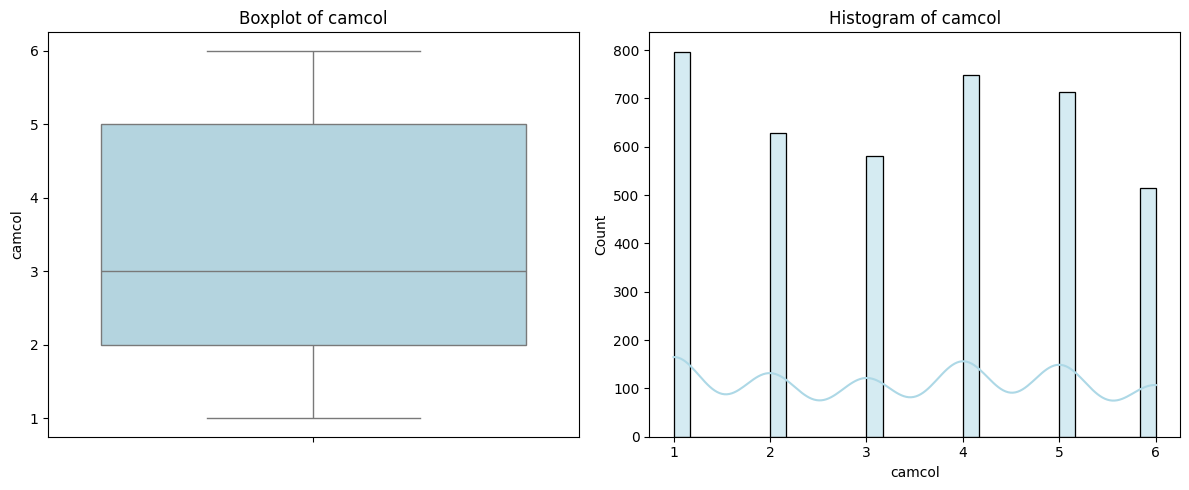

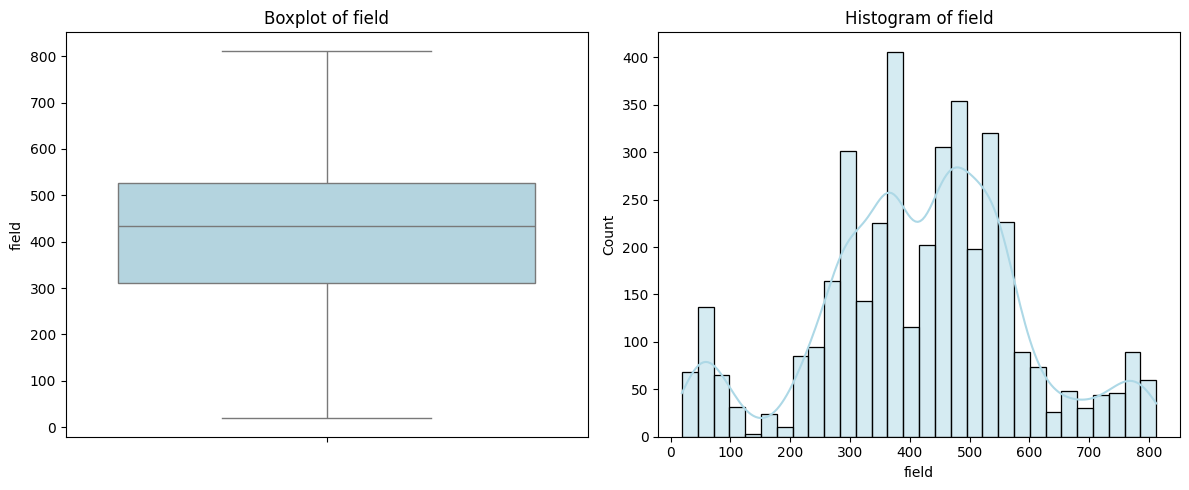

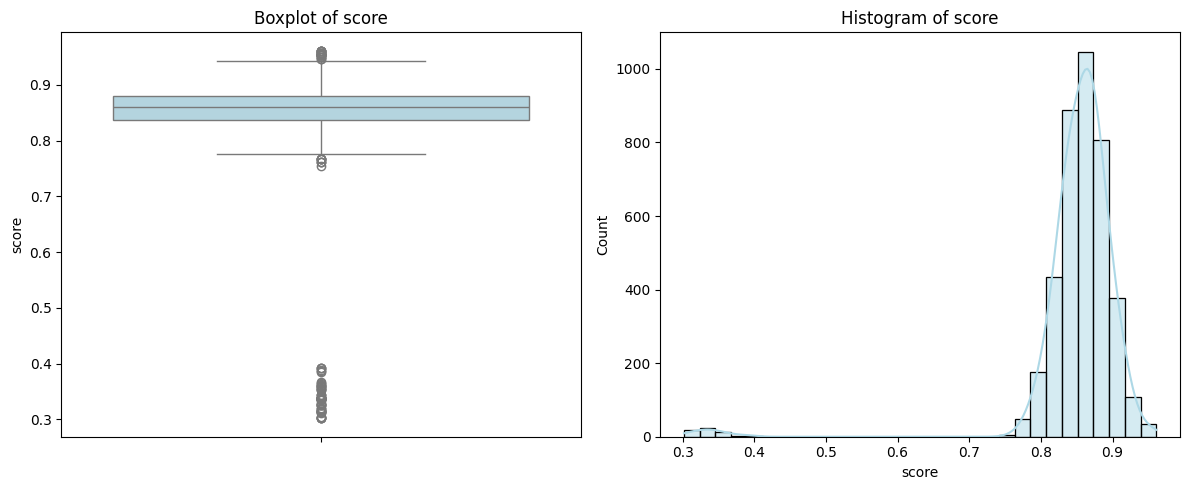

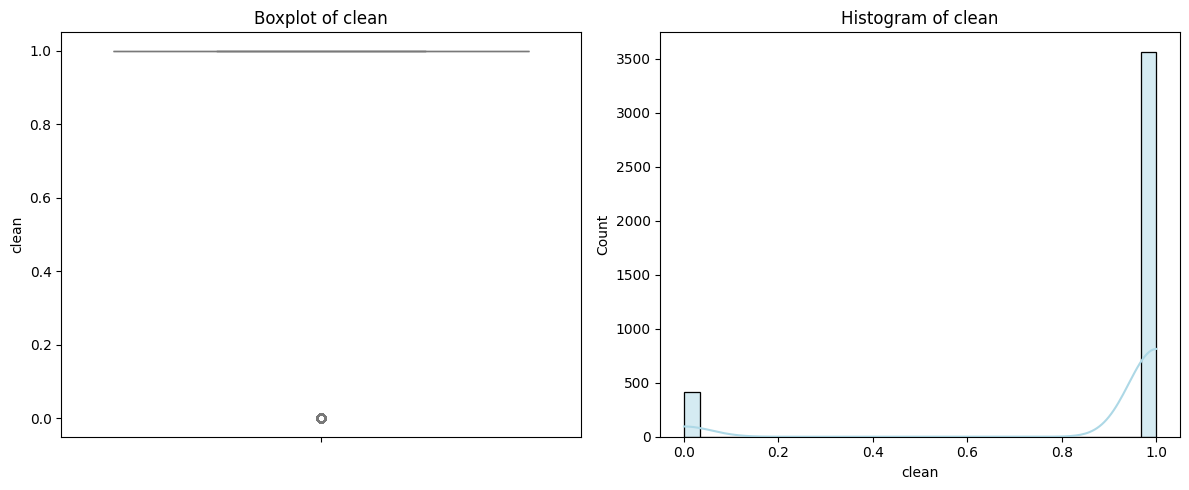

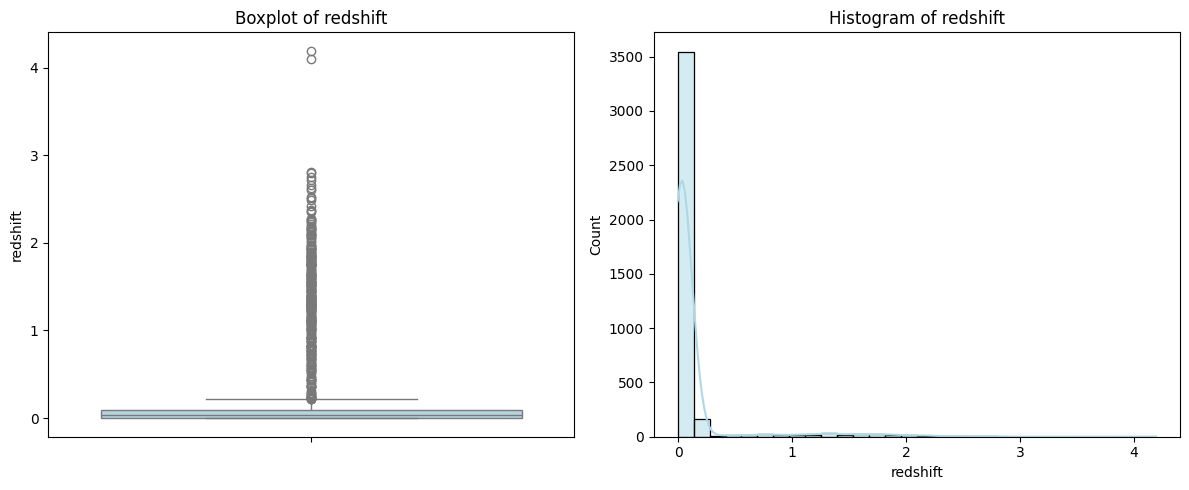

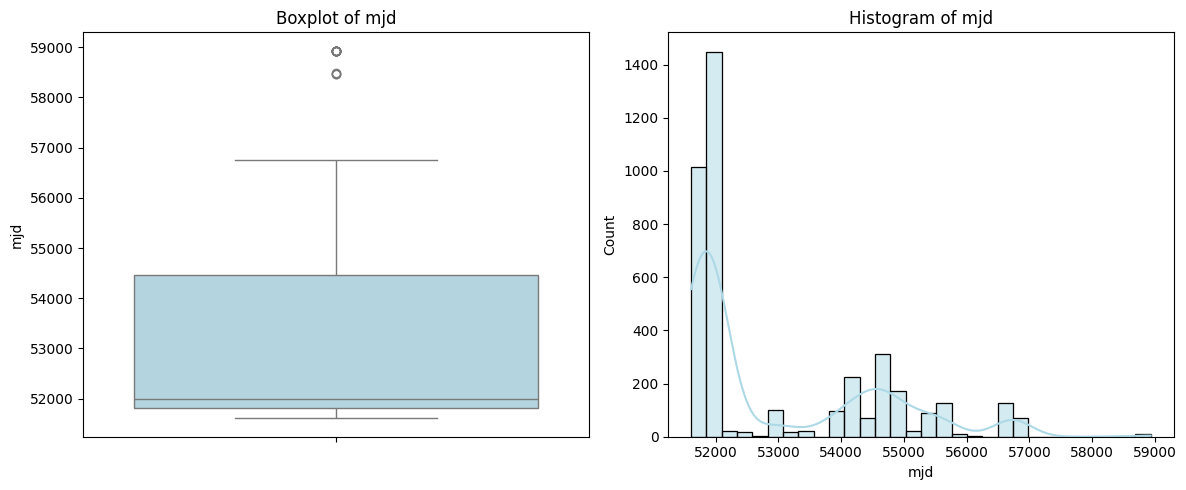

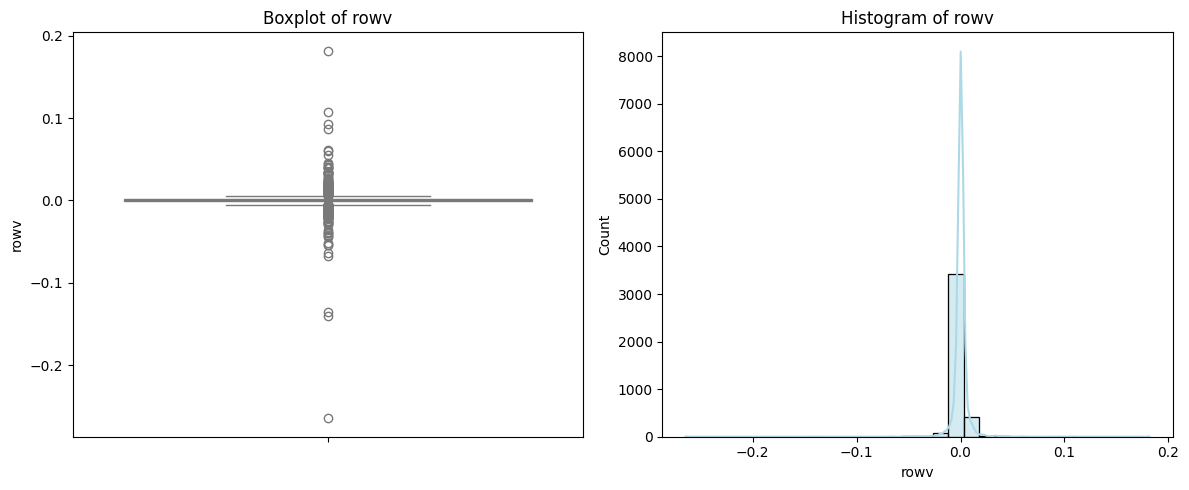

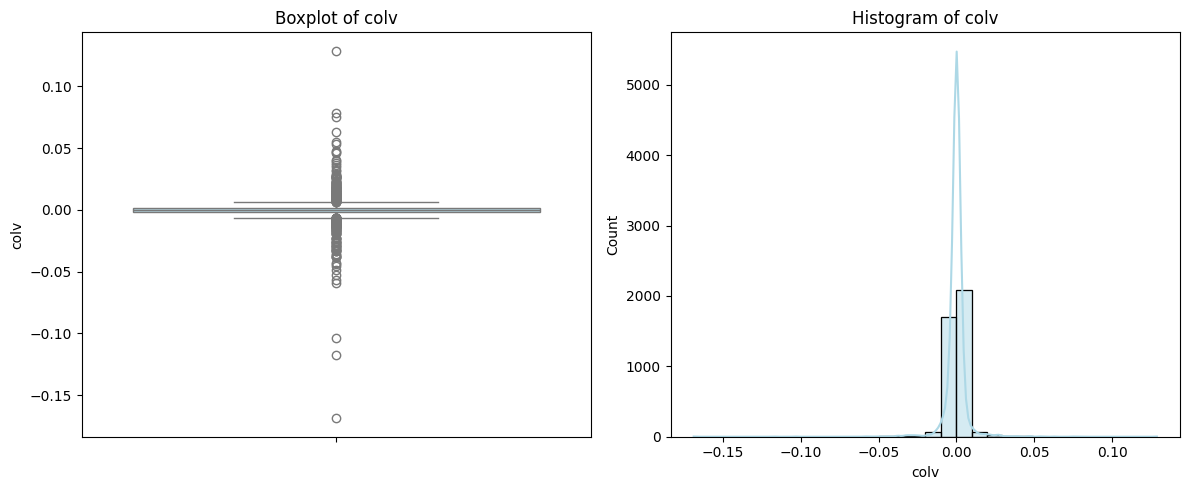

In [ ]:
def plot_outliers(df, column):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Boxplot
    sns.boxplot(y=df[column], ax=axes[0], color='lightblue')
    axes[0].set_title(f'Boxplot of {column}')

    # Histogram
    sns.histplot(df[column], bins=30, kde=True, ax=axes[1], color='lightblue')
    axes[1].set_title(f'Histogram of {column}')

    plt.tight_layout()
    plt.show()

for i, var in enumerate(vars_to_plot):
    plot_outliers(trainData, var)



De acuerdo con los histogramas, podemos ver que hay algunas columnas que siguen dispersiones ya conocidas o tendencias marcadas. En particular:

1.   u tiene un crecimiento exponencial o polinomial
2.   g, r, z tienen un comportamiento de distribución normal (puede que en algunas columnas la tendencia no sea tan central, pero tiene forma de normal).
3. Score tiene una campana con tendencia a la derecha.
4. Rowv y colv tienen velocidades cercanas a 0, con una campana bastante alta




# PARTE 2-> Entendimiento de datos -Preparación de datos

## Variables categoricas
Encontramos algunas variables categoricas al hacer el entendmiento de datos

In [ ]:
trainData["camcol"] = trainData["camcol"].astype("category")
#df["run"] = df["run"].astype("category")
trainData["clean"] = trainData["clean"].astype("category")
trainData["class"] = trainData["class"].astype("category")
display(trainData[["camcol", "clean", "class"]])

,camcol,clean,class
0,5,1,STAR
1,1,1,GALAXY
2,2,1,GALAXY
3,2,1,GALAXY
4,1,1,STAR
...,...,...,...
3995,2,1,STAR
3996,1,1,STAR
3997,1,1,GALAXY
3998,3,1,GALAXY


In [ ]:
trainData["field"].value_counts()

,count
field,
482,32
365,30
368,27
369,27
362,27
...,...
19,1
637,1
666,1


## Datetime
Hicimos la transformación de los días en julianos a días normales

In [ ]:
trainData["mjd_date"] = pd.to_datetime(trainData["mjd"] + 2400000.5, origin="julian", unit="D")
display(trainData["mjd_date"])

,mjd_date
0,2007-02-09
1,2001-02-15
2,2001-01-04
3,2001-02-19
4,2008-04-06
...,...
3995,2009-03-01
3996,2004-08-25
3997,2001-03-17
3998,2011-11-23


(array([1.015e+03, 1.449e+03, 2.100e+01, 1.800e+01, 4.000e+00, 1.000e+02,
        1.900e+01, 2.100e+01, 0.000e+00, 9.600e+01, 2.230e+02, 6.900e+01,
        3.120e+02, 1.730e+02, 2.300e+01, 8.800e+01, 1.280e+02, 1.000e+01,
        1.000e+00, 0.000e+00, 1.260e+02, 7.200e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.200e+01]),
 array([11021.        , 11265.13333333, 11509.26666667, 11753.4       ,
        11997.53333333, 12241.66666667, 12485.8       , 12729.93333333,
        12974.06666667, 13218.2       , 13462.33333333, 13706.46666667,
        13950.6       , 14194.73333333, 14438.86666667, 14683.        ,
        14927.13333333, 15171.26666667, 15415.4       , 15659.53333333,
        15903.66666667, 16147.8       , 16391.93333333, 16636.06666667,
        16880.2       , 17124.33333333, 17368.46666667, 17612.6       ,
        17856.73333333, 18100.86666667, 18345.        ]),
 <BarContainer object of 30 artists>)

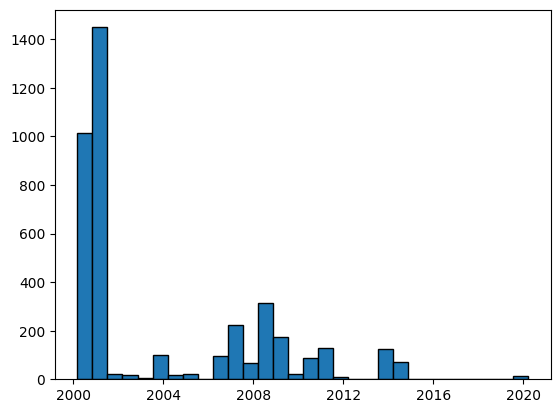

In [ ]:
plt.hist(trainData["mjd_date"], bins=30, edgecolor="black")

Variables que son númericas:
coordenadas: ra', 'dec',
magnitudes:'u', 'g', 'r', 'i', 'z',  'redshift
numero de observación:'run',
       'score',
       
 categoricas:'class',''rowv', 'colv'

 fechas:'mjd_date'

## Transformaciones
Con las dispersiones observamos que las columnas:
1. Vamos a transformar u a logaritmica, sqrt, y log en base 2, debido a que vemos en la dispersión que tiene una tendencia exponencial/polinomica. A partir de esas transformaciones vamos a evaluar cual da un mejor resultado en la regresión.

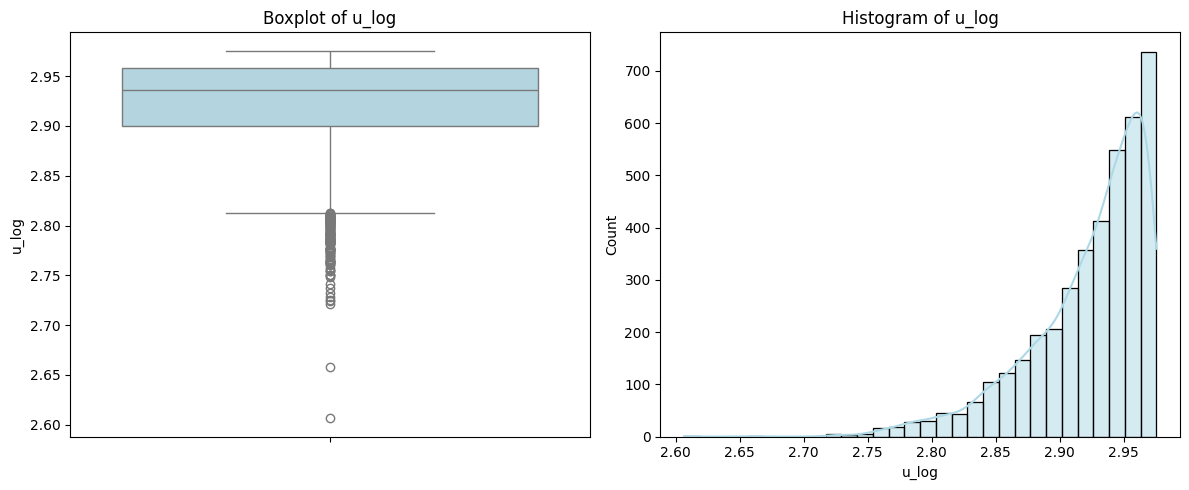

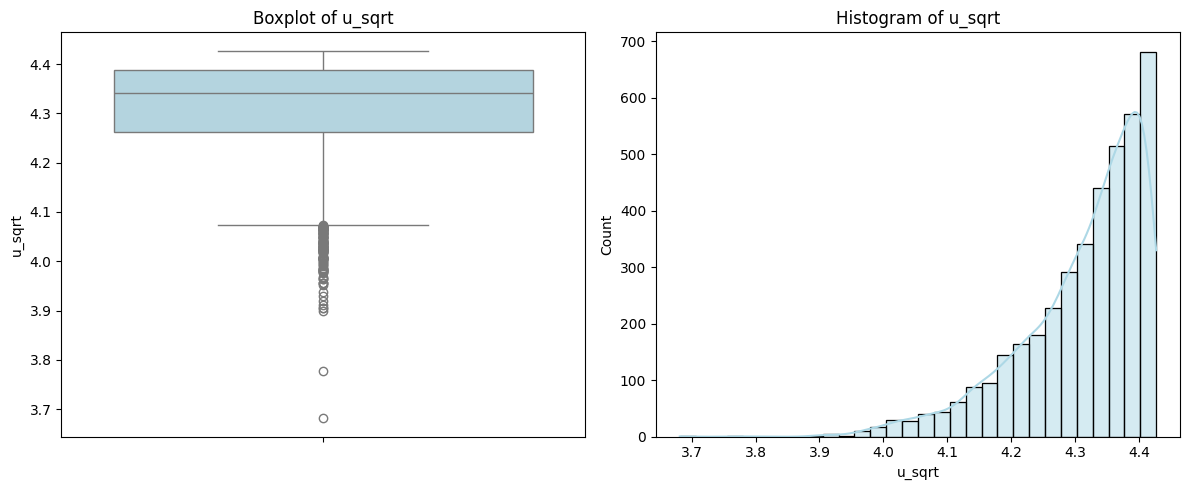

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


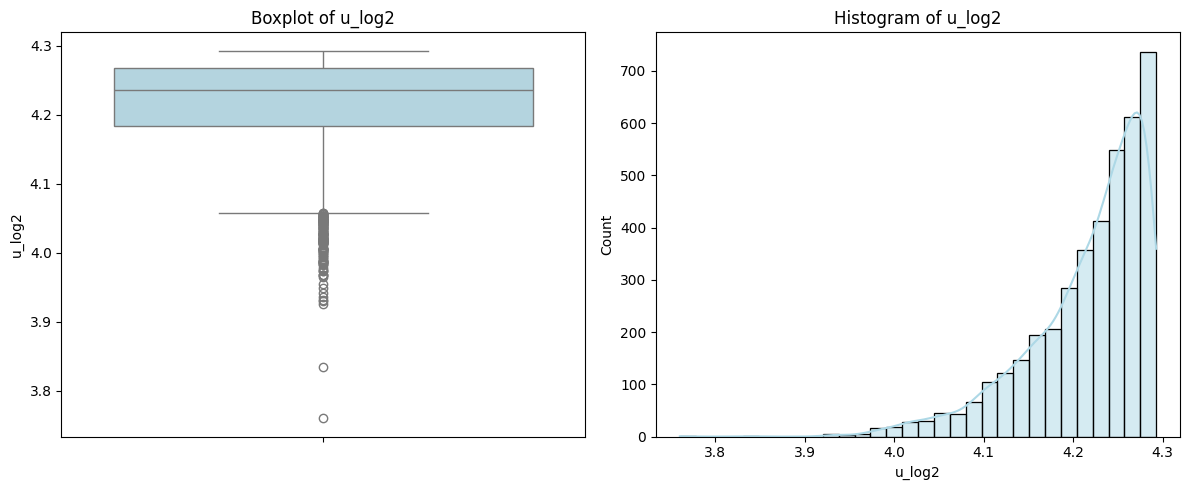

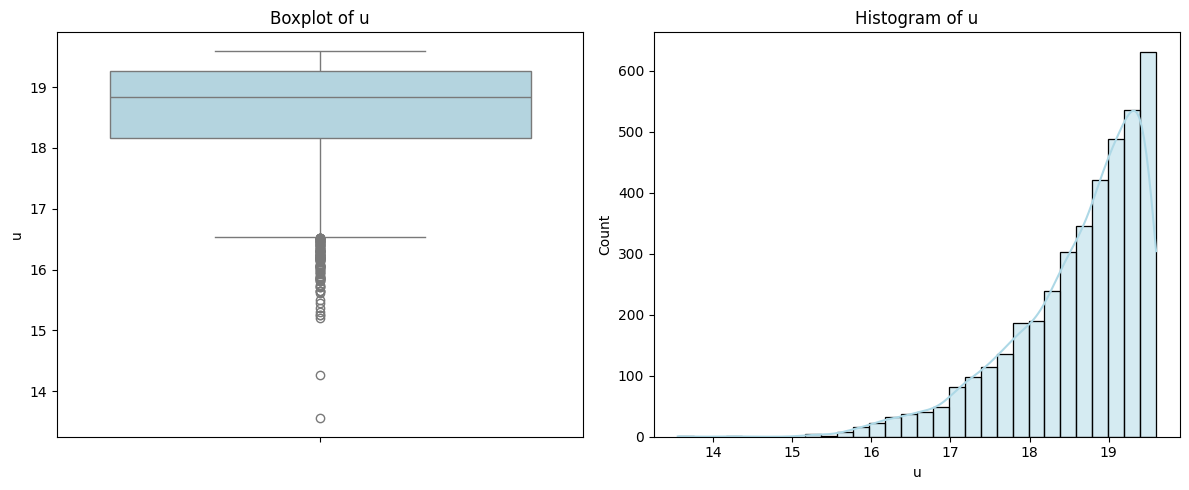

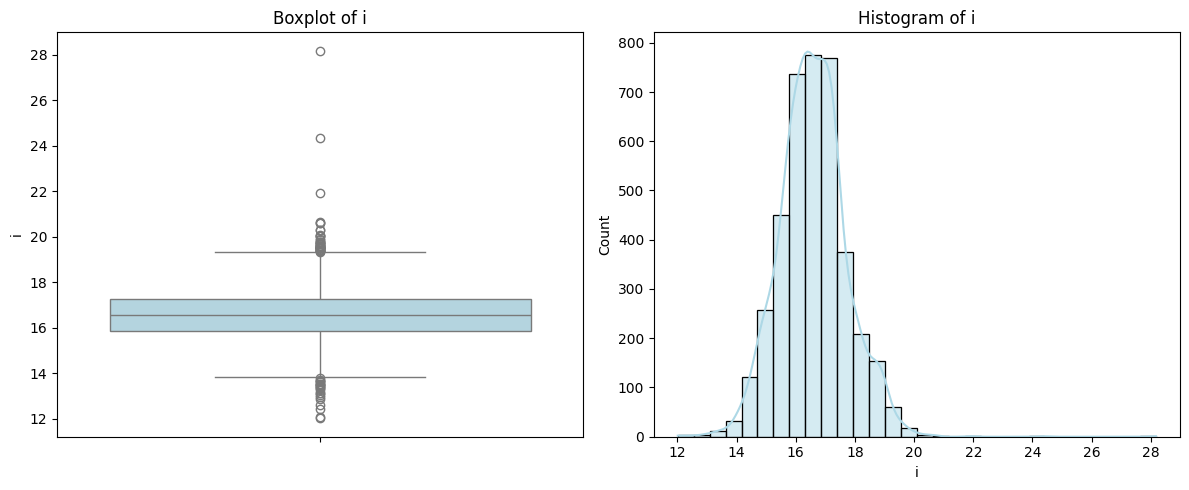

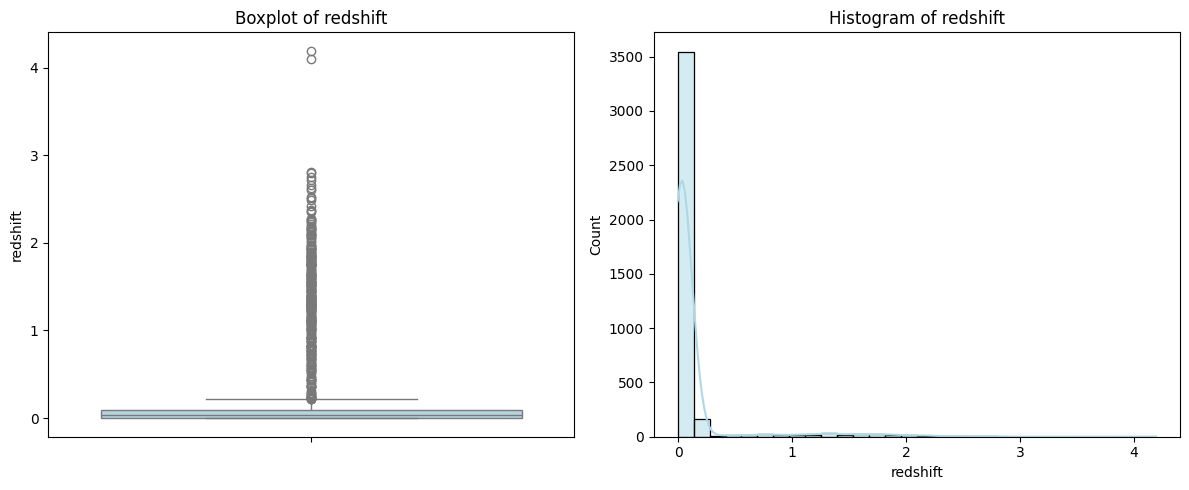

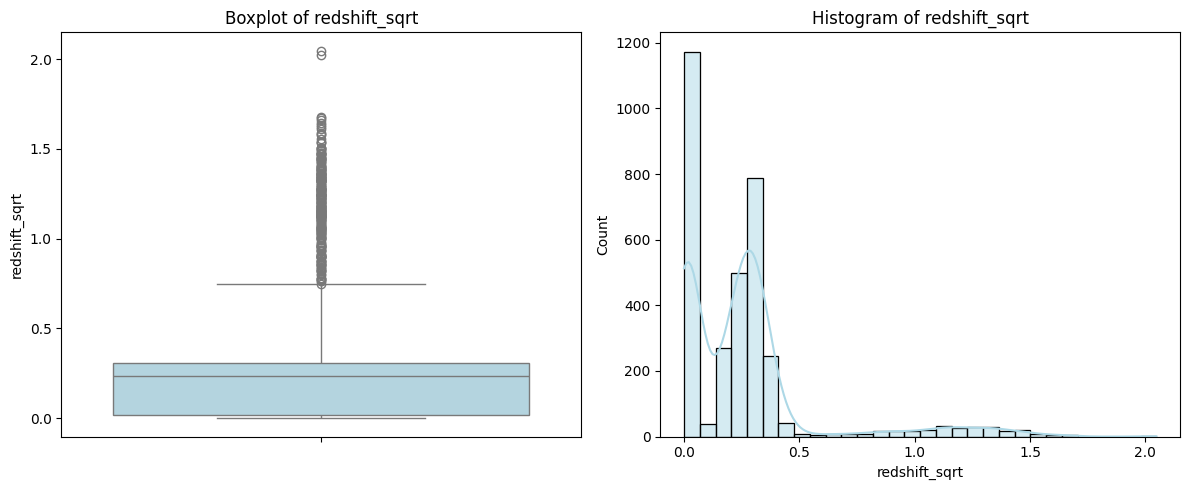

In [ ]:
trainData["u_log"] = np.log(trainData["u"])
plot_outliers(trainData, "u_log")
trainData["u_sqrt"] = np.sqrt(trainData["u"])
plot_outliers(trainData, "u_sqrt")
trainData["u_log2"] = np.log2(trainData["u"])
plot_outliers(trainData, "u_log2")
plot_outliers(trainData, "u")
plot_outliers(trainData, "i")

2. Realizamos dummies de la variable class, dado que es una variable categorica.

In [ ]:
import pandas as pd
print(trainData["class"].value_counts())

trainData_encoded = pd.get_dummies(trainData, columns=["class"], drop_first=True)

print(trainData_encoded.head(5))

class
GALAXY    1891
STAR      1800
QSO        292
Name: count, dtype: int64
                 objid          ra       dec         u         g         r  \
0  1237648722306924571  185.574486  0.701402  19.11034  17.62099  17.03464   
1  1237648720167436418  203.801841 -0.853906  18.90957  17.62940  17.01465   
2  1237648720685105352  160.034264 -0.421626  19.26340  17.67693  16.82551   
3  1237648703510937836  200.807373 -0.682024  18.82022  17.77765  17.38575   
4  1237648720161275992  189.792404 -1.001480  18.91391  19.05355  19.46278   

          i         z  run camcol  field     score clean      redshift    mjd  \
0  16.82993  16.71711  756      5    466  0.864145     1  8.780529e-05  54140   
1  16.62059  16.35239  756      1    588  0.816541     1  8.619995e-02  51955   
2  16.42307  16.13864  756      2    295  0.870381     1  1.330486e-01  51913   
3  17.11128  16.93540  752      2    382  0.867801     1  8.636355e-02  51959   
4  19.75660  20.09613  756      1    494  0.83382

# PARTE 3->  Proceso de selección de variables
De acuerdo a la etapa de entendimiento de datos (nos basamos en todas las gráficas que estaban en esa sección) y la investigación de redshift notamos que hay algunas variables que no son relevantes para predecir este valor.

En primer lugar, **run, camcol, field ** son columnas sobre como el telescopio registró la imagen, no sobre el objeto en sí. En el entendimiento de datos se pueden ver hasta categoricas, o que tienen valores únicos especificos. Por lo tanto, no la vamos a tener en cuenta para la regresion.

En segundo lugar, la fecha **mjd** en la que se tomo la foto no tiene que ver con el redshift del objeto (según lo que investigamos). En el histograma de la fecha vemos que muchos registros están el 2000, así que no lo vamos a tomar como relevante.

## Matriz de correlación

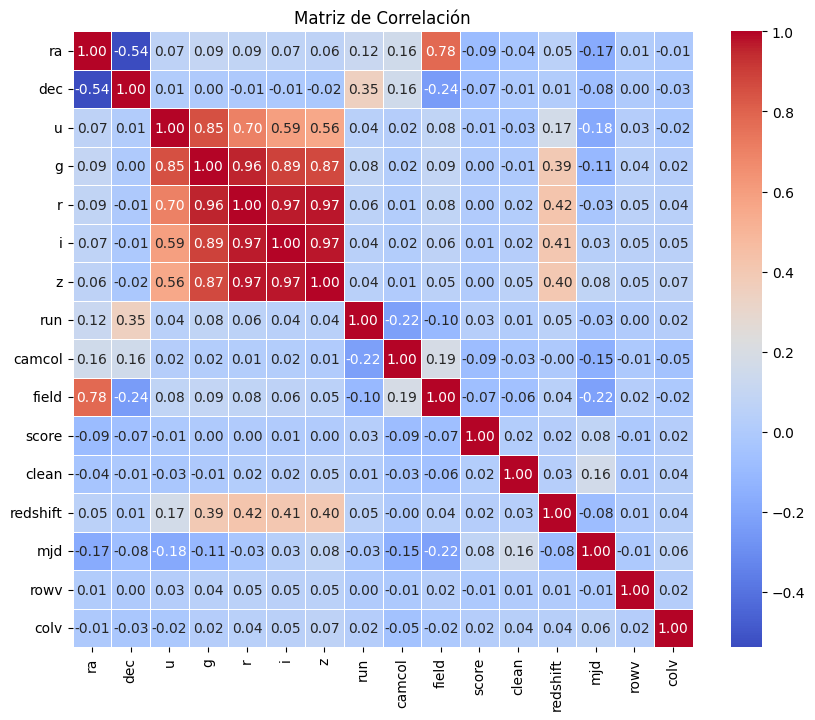

In [ ]:
corr_matrix= trainData[vars_to_plot].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

La matriz de correlación muestra una alta colinealidad entre las magnitudes u, g, r, i y z, con valores superiores a 0.85, lo que indica que estas variables están fuertemente relacionadas. También se observa que field tiene una fuerte correlación negativa con ra (-0.78), lo que sugiere una posible dependencia espacial. En contraste, redshift no muestra correlaciones fuertes con ninguna variable, lo que indica que su relación con las demás características no es linealmente evidente.

In [ ]:
#vars iniciales: ra	dec	u	g	r	i	z	run	camcol	field	score	clean	redshift	mjd	rowv	colv
#Las variables que seleccionamos son:
#clean nos sirve para filtrar
vars = ["ra", "dec", "u", "u_log", "u_log2", "u_sqrt",	"g",	"r",	"i",	"z", "score","clean", "class_QSO", "class_STAR", "rowv", "colv"]

Después de tener menos variables comenzamos a probar la regresión, nos dimos de cuenta que score y clean no eran necesarias en la regresión porque nos decian que tan buenos estaba el registro y la calidad de este. En el entendmiento de datos vemos que el score promedio es de 0.85 y que la mayoria de veces clean están en 1, así que consideramos que cuando se vaya a usar en un modelo en un futuro es muy probable que los datos también estén limpios.

ra y dec en el entendimiento de datos nos daban valores de grados que representaban la ascensón y la declinación, en estas gráficas veiamos que muchos de los registros se concentraban en ciertas partes, esto quiere decir que eran registros de una zona del espacio. Por tal razón, y por la definición del redshift, no hayamos necesario poner estas variables que eran coordenadas.

**VARIABLES FINALES:** "u_log2",	"g",	"r",	"i",	"z", "rowv", "colv", "class_QSO", "class_STAR"

# PARTE 3 -> Regresión

In [ ]:
vars_1 = [ "u_log2",	"g",	"r",	"i",	"z", "rowv", "colv", "class_QSO", "class_STAR"]
X_train, X_test, y_train, y_test = train_test_split(trainData_encoded[vars_1], trainData["redshift"], test_size=0.3, random_state=1)
scalate = 0

if scalate:
  # Scale the features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Train the model
  regression = LinearRegression()
  regression.fit(X_train_scaled, y_train)
  y_pred = regression.predict(X_test_scaled)

else:
  regression = LinearRegression()
  regression.fit(X_train, y_train)
  y_pred = regression.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('MAE:', round(mean_absolute_error(y_test, y_pred),4))
print('MSE:', round(mean_squared_error(y_test, y_pred),4))
print('R^2:', round(r2_score(y_test, y_pred),4))
print('RMSE:', round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

MAE: 0.0593
MSE: 0.029
R^2: 0.7819
RMSE: 0.1702


Los resultados muestran que el modelo tiene un desempeño aceptable. El  R² (0.7819) indica que el modelo explica el 78.19% de la variabilidad de los datos, lo que sugiere un buen ajuste, aunque con margen de mejora. El MAE (0.0593) indica que, en promedio, las predicciones tienen un error de 0.0593 unidades, lo cual, es bajo al revisar los valores del redshift. El MSE (0.029) y el RMSE (0.1702) también tienen una magnitud aceptable, que muestra que los errores grandes tienen un impacto significativo, pero no impacta demasiado.

## Comparación valores clave regresión. XTrain - Xtest

In [ ]:
print("Train MAE:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test MAE:", mean_absolute_error(y_test, regression.predict(X_test)))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train MAE: 0.059654740555142645
Test MAE: 0.05929401858249717
Train RMSE: 0.19261066714179617
Test RMSE: 0.17017264815428268


# PARTE 4 - EVALUACIÓN CUANTITATIVA  - Análisis del error
En esta sección hicimos un análisis previo de como quedó el modelo

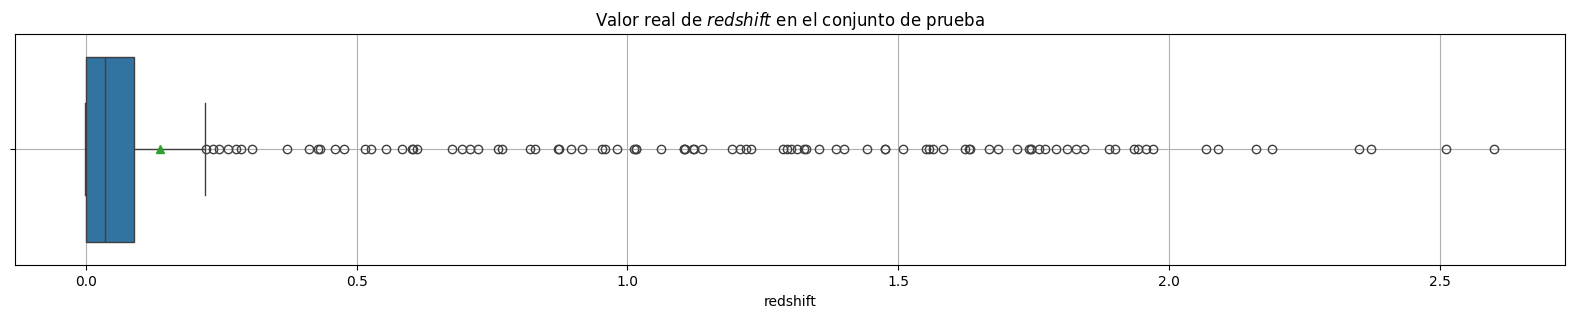

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{redshift}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [ ]:
 y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

,redshift
count,1195.000000
mean,0.136507
std,0.364540
min,-0.000964
25%,0.000112
50%,0.034946
75%,0.088468
99%,1.902343
max,2.601201


In [ ]:
y_train.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

,redshift
count,2788.000000
mean,0.133342
std,0.387181
min,-0.003322
25%,0.000104
50%,0.029852
75%,0.085879
99%,2.061264
max,4.192597


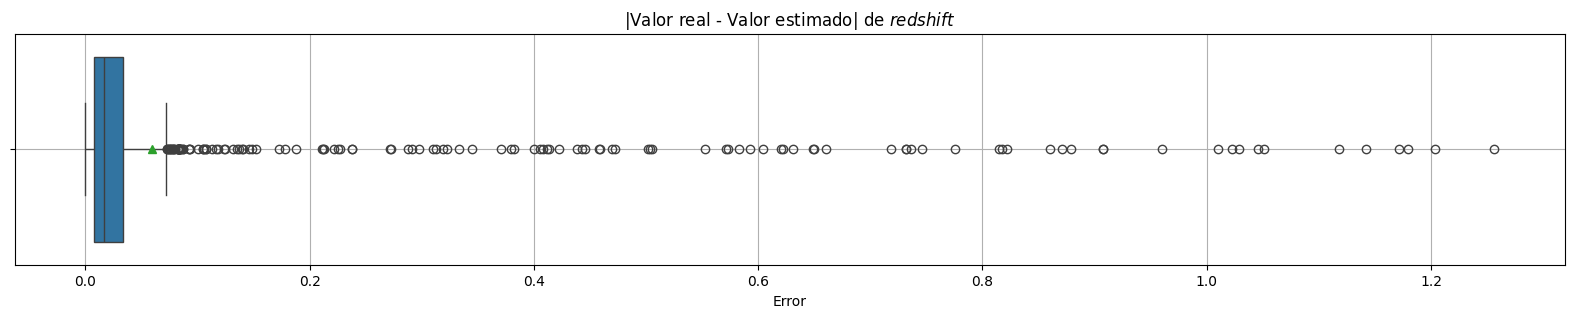

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{redshift}$")
plt.xlabel("Error")
plt.grid()
plt.show()

Desde un punto de vista cuantitativo, y de acuerdo con las gráficas  anteriormente obtenidas muestran que el modelo tiene un desempeño aceptable para la predicción de valores de redshift (R2 cercano a 0.8). Sin embargo, en algunos momentos su precisión disminuye a medida que el redshift aumenta. Esto se refleja en un incremento del error y una mayor desviación en las predicciones, lo que afecta el cumplimiento de los supuestos relacionados con la distribución de errores y la estabilidad de la varianza.

Debido a estas limitaciones, no recomendamos implementar el modelo actual en producción, ya que su desempeño no es consistente en todo el rango de valores de redshift. Para mejorar el modelo, se podrían explorar estrategias como la inclusión de nuevas variables predictoras, la segmentación del modelo en rangos específicos de redshift para mejorar su precisión en valores altos. Además, se podría profundizar en técnicas de tratamiento de outliers y transformaciones que reduzcan la heterocedasticidad en los errores.


# PARTE 5 -> EVALUACIÓN CUALITATIVA

## Validación de supuestos de la regresión

##  Colinealidad
Para revisar la colineaalidad hicimos un mapa de correlaciones entre las variables de la regresión

También hicimos una prueba de inflación de la varianza

<Axes: >

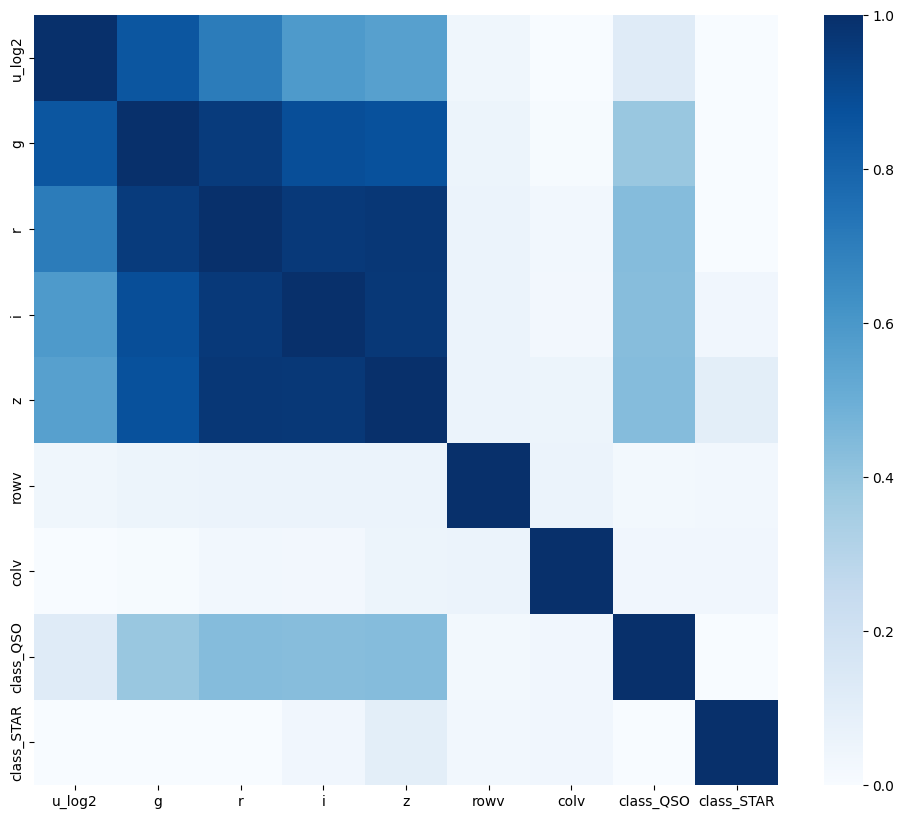

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

 Hay  problemas  de  multicolinealidad  cuando  los  regresores están relacionados  linealmente  entre  ellos, esto es un problema frecuente debido a efectos de aleatoriedad. En este caso hay una alta colinealidad entre algunas variables, especialmente entre u_log2, g, r, i y z, que son magnitudes. Era esperado, ya que representan magnitudes que suelen estar correlacionadas entre si. Al revisar como funciona el red shift encontramos que r, i, z es más frio y u y g son más objetos calientes. Puede que la correlación sea alta porque están midiendo el mismo objeto.

 Las variables rowv,colv, class  no muestran una correlación fuerte con las demás, por lo que no generan problemas de multicolinealidad.


In [ ]:
 X_train.corr()

,u_log2,g,r,i,z,rowv,colv,class_QSO,class_STAR
u_log2,1.000000,0.854944,0.709666,0.588980,0.562301,0.041749,-0.030209,0.121781,-0.284380
g,0.854944,1.000000,0.956200,0.884977,0.872346,0.055940,0.008048,0.388230,-0.202506
r,0.709666,0.956200,1.000000,0.964467,0.969928,0.059472,0.032240,0.435691,-0.062900
i,0.588980,0.884977,0.964467,1.000000,0.968380,0.058953,0.028203,0.431541,0.036411
z,0.562301,0.872346,0.969928,0.968380,1.000000,0.059238,0.056885,0.434077,0.104131
rowv,0.041749,0.055940,0.059472,0.058953,0.059238,1.000000,0.058867,0.026828,0.034655
colv,-0.030209,0.008048,0.032240,0.028203,0.056885,0.058867,1.000000,0.038237,0.038744
class_QSO,0.121781,0.388230,0.435691,0.431541,0.434077,0.026828,0.038237,1.000000,-0.255193
class_STAR,-0.284380,-0.202506,-0.062900,0.036411,0.104131,0.034655,0.038744,-0.255193,1.000000



## Linealidad

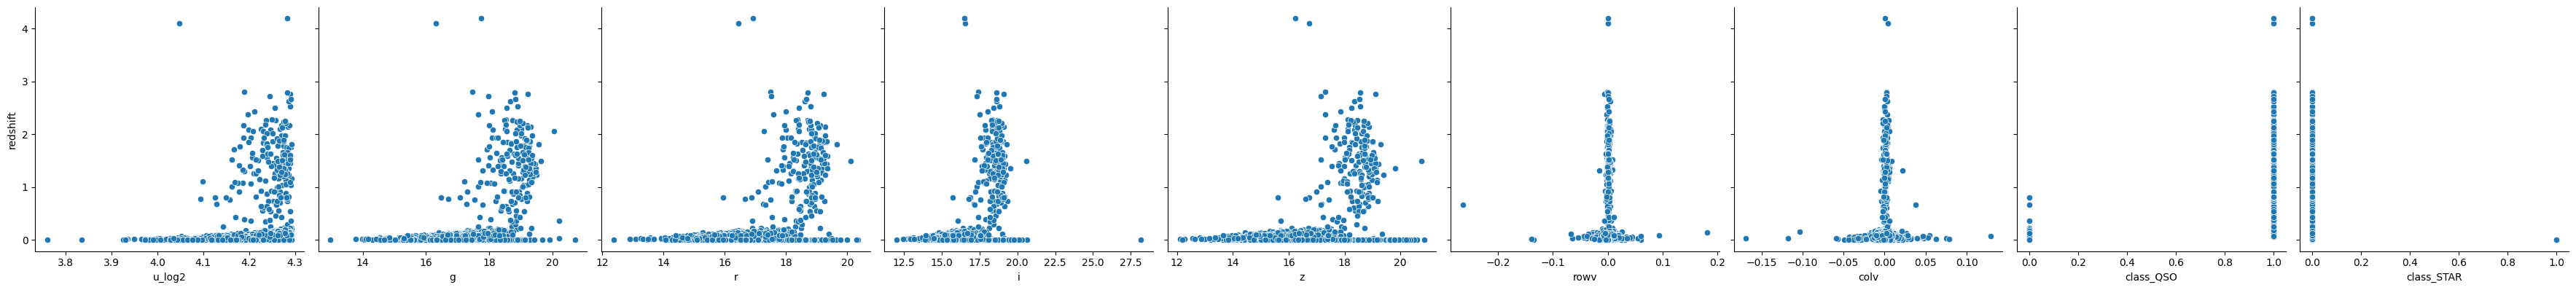

In [ ]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars="redshift", x_vars=vars_1, kind="scatter")

La relación en algunas variables como g, r e i no se ve tan lineal, mostrando una mayor dispersión en valores más altos de redshift. Se hizo una transformación en la variable u a u_log2 antes de la regresión porque su dispersión no parecía lineal. Para esta prueba, no se encuentra ninguna tendencia muy marcada en general en todas las variables, por lo que decidimos dejarlo así.

## Indepedencia de **errores**
Este supuesto es-> Los errores deben ser independientes entre sí. Utilizamos la prueba de durbin_watson para revisar este supuesto. Si es cercano a 2, se cumple con el supuesto

In [ ]:
from statsmodels.stats.stattools import durbin_watson

residuos =abs(y_test - regression.predict(X_test))
dw_stat = durbin_watson(residuos)
print("Durbin-Watson:", dw_stat)

Durbin-Watson: 1.7871996870802822


Es cercano a 2 así que hay independencia en los errores. Es decir, no hay evidencia de que los errores de predicción estén correlacionados temporalmente o secuencialmente

## Homoscedasticidad
Los errores deben tener varianza constante. La  violación  de  este  supuesto  tiene  implicaciones  en  la estimación de la varianza.

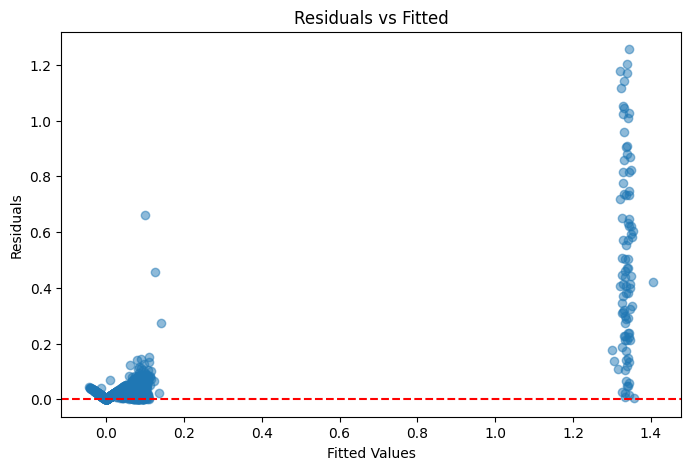

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

Como se puede observar, los residuales si tienden a tener concentración en cero, sin embargo no se distribuyen de manera aleatoria ya que estan distribuidos en dos bandas. Esto indica problemas de heterocedasticidad a primer vistazo.

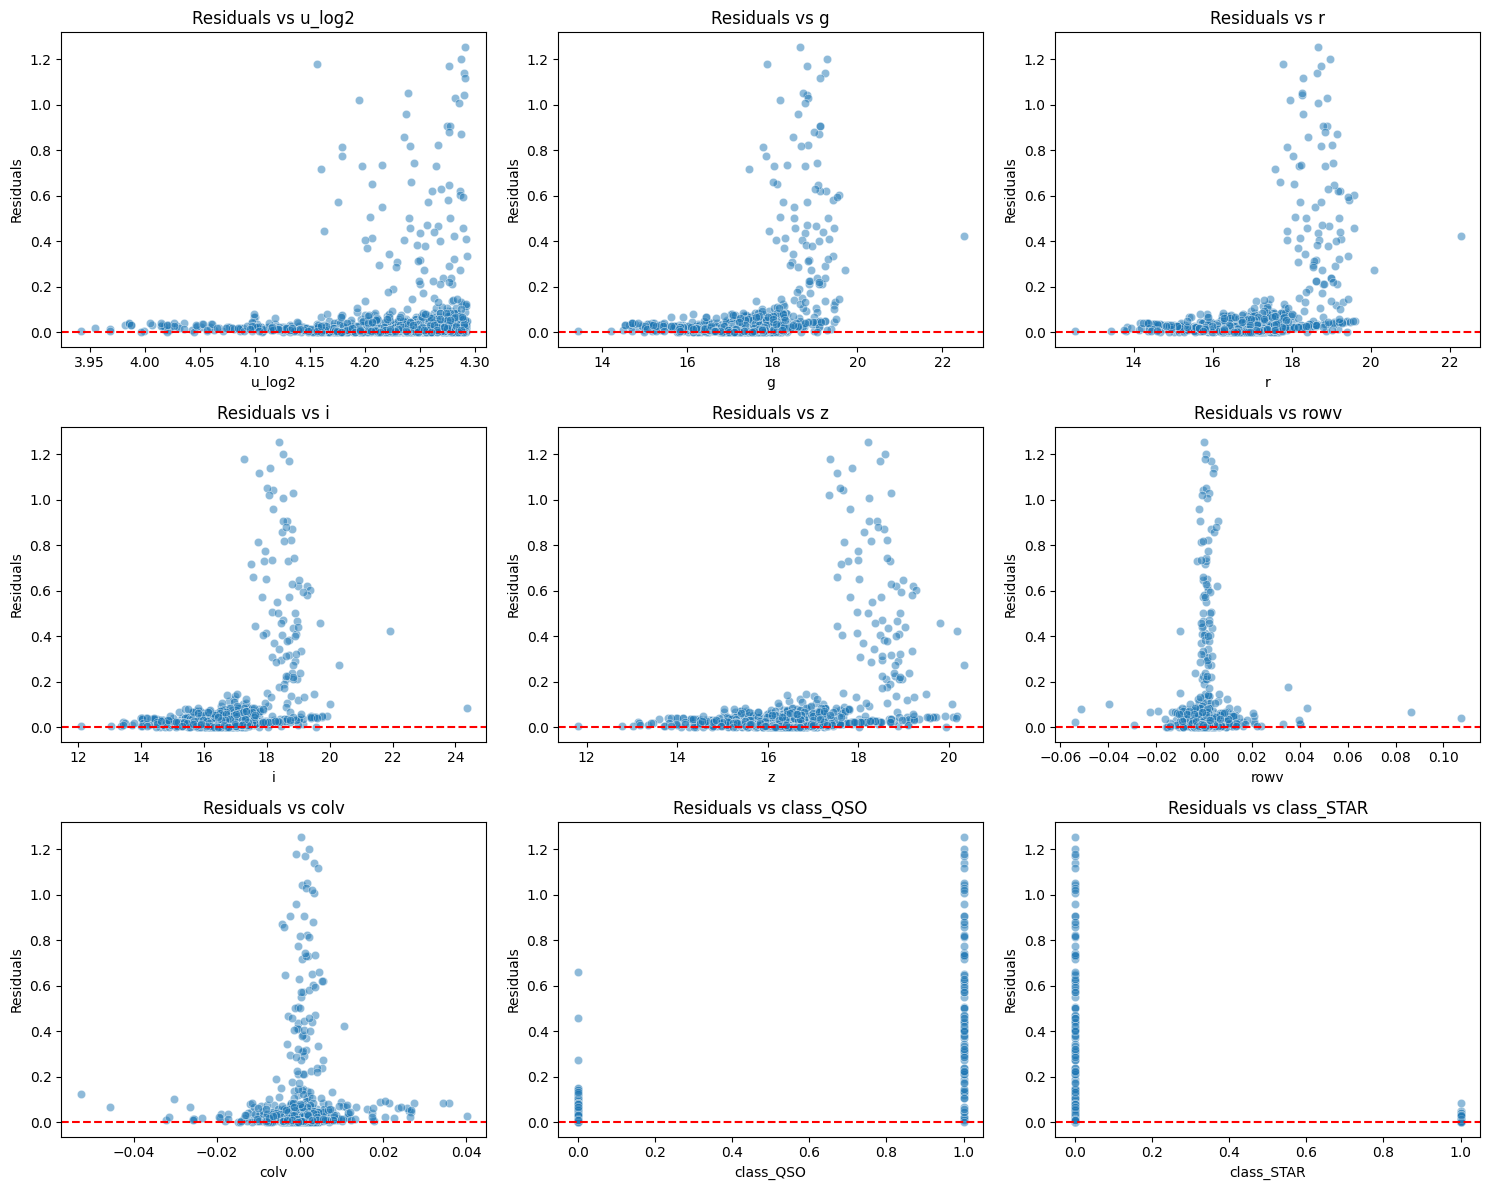

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(vars_1):
    sns.scatterplot(x=X_test[var], y=residuos, alpha=0.5, ax=axes[i])
    axes[i].axhline(y=0, color='r', linestyle='--')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Residuals")
    axes[i].set_title(f"Residuals vs {var}")

plt.tight_layout()
plt.show()

Graficamos los residuales contra las variables individuales y se puede observar que la mayoria (u_log2, g, r, i ,z) tienen estructura de embudo, los residuales tienden a tener mayor  dispersión en valores grandes que pequeños. Esto se puede deber a que el modelo tiene más dificultad determinando valores de redshift mayores.

In [ ]:


from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuos, sm.add_constant(X_test))
print(f"Breusch-Pagan p-valor: {bp_test[1]:.4f} (Si <0.05 → hay heteroscedasticidad)")

Breusch-Pagan p-valor: 0.0000 (Si <0.05 → hay heteroscedasticidad)


Se realiza la prueba de breush pagan y se confirman problemas de heterocedasticidad.

In [ ]:
import statsmodels.stats.diagnostic as smd

import statsmodels.stats.diagnostic as smd

# Asegurar que X_test tiene una constante
X_test_const = sm.add_constant(X_test)

# Ejecutar el test de White
white_test = smd.het_white(resid=residuos, exog=X_test_const)

# Mostrar p-valor del test
print(f"White Test p-value: {white_test[1]}")
print(white_test)


White Test p-value: 1.3026765793911619e-160
(924.286616052384, 1.3026765793911619e-160, 76.51965284350574, 0.0)


[link text](https://)

## Normalidad de los residuos

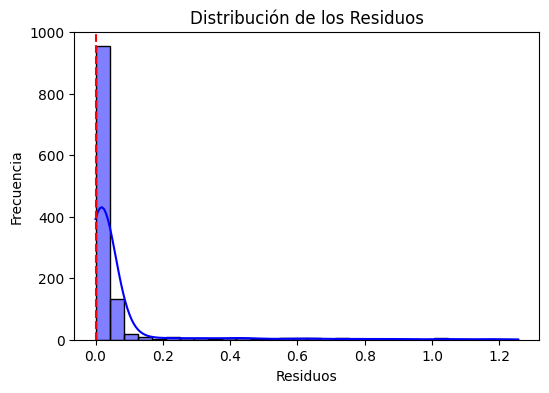

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(residuos, kde=True, bins=30, color="blue")
plt.axvline(x=0, color='red', linestyle="--")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribución de los Residuos")
plt.show()

In [ ]:
shapiro_test = stats.shapiro(residuos)
print(f"Shapiro-Wilk p-valor: {shapiro_test.pvalue:.4f} (Si <0.05 → residuos no normales)")

Shapiro-Wilk p-valor: 0.0000 (Si <0.05 → residuos no normales)


Se destaca un sesgo positivo en los residuales, por ende no siguen una distribución normal. La mayoria estan concentrados alrededor de cero que puede indicar la presencia de outliers

## Otro intento de modelo con transformaciones

Sacamos el promedio de ug y riz, y realizamos otros intentos de transformaciones intermedias

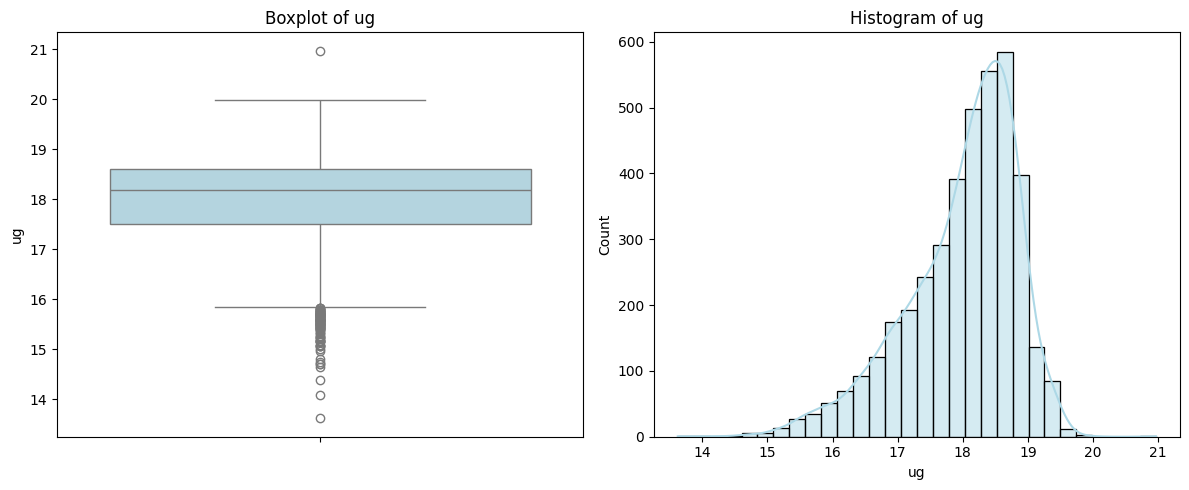

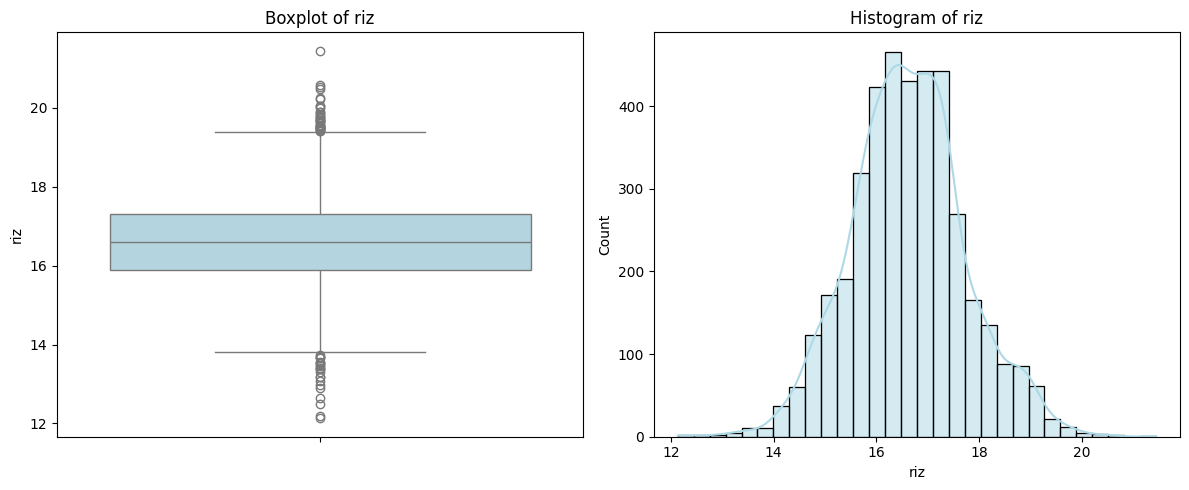

MAE: 0.0593
MSE: 0.029
R^2: 0.7819
RMSE: 0.1702


In [ ]:
vars_2 = [ "ug", "riz", "rowv", "colv", "class_QSO", "class_STAR"]
trainData_encoded["g_sqrt"] = np.sqrt(trainData_encoded["g"])
trainData_encoded["r_sqrt"] = np.sqrt(trainData_encoded["r"])
trainData_encoded["i_sqrt"] = np.sqrt(trainData_encoded["i"])
trainData_encoded["z_sqrt"] = np.sqrt(trainData_encoded["z"])
trainData_encoded["riz"] = (trainData_encoded["r"] + trainData_encoded["i"] + trainData_encoded["z"])/3
trainData_encoded["ug"] = (trainData_encoded["g"] + trainData_encoded["u"] )/2
plot_outliers(trainData_encoded, "ug")
plot_outliers(trainData_encoded, "riz")
X_train1, X_test1, y_train1, y_test1 = train_test_split(trainData_encoded[vars_2], trainData["redshift"], test_size=0.3, random_state=1)
scalate = 0

if scalate:
  # Scale the features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Train the model
  regression = LinearRegression()
  regression.fit(X_train_scaled, y_train)
  y_pred1 = regression.predict(X_test_scaled)

else:
  regression1 = LinearRegression()
  regression1.fit(X_train, y_train)
  y_pred1 = regression.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print('MAE:', round(mean_absolute_error(y_test1, y_pred1),4))
print('MSE:', round(mean_squared_error(y_test1, y_pred1),4))
print('R^2:', round(r2_score(y_test1, y_pred1),4))
print('RMSE:', round(np.sqrt(mean_squared_error(y_test1, y_pred1)), 4))

In [ ]:
print("Columnas en X_train1:", X_train1.columns)
print("Columnas en X_test1:", X_test1.columns)


Columnas en X_train1: Index(['ug', 'riz', 'rowv', 'colv', 'class_QSO', 'class_STAR'], dtype='object')
Columnas en X_test1: Index(['ug', 'riz', 'rowv', 'colv', 'class_QSO', 'class_STAR'], dtype='object')


In [ ]:
#  X_train1.corr()
#  sns.pairplot(pd.concat([X_train1, y_train1], axis=1), height=4, y_vars="redshift", x_vars=vars_2, kind="scatter")


# #  from statsmodels.stats.stattools import durbin_watson

# residuos1 =abs(y_test1 - regression1.predict(X_test1))
# # dw_stat = durbin_watson(residuos1)
# # print("Durbin-Watson:", dw_stat)

# plt.figure(figsize=(8, 5))
# plt.scatter(y_pred, residuos1, alpha=0.5)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel("Fitted Values")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Fitted")
# plt.show()

Los resultados de esta regresión se encuentran en la presentación. Se decidió seguir con el modelo inicial, porque en los otros intentos de regresión no había mejoría de los errores.

## Coeficientes modelo inicial

In [ ]:
pd.DataFrame({"columns": vars_1, "coef": regression.coef_})

,columns,coef
0,u_log2,0.069545
1,g,-0.021585
2,r,0.036710
3,i,0.006223
4,z,-0.010342
5,rowv,-0.705419
6,colv,0.425425
7,class_QSO,1.222860
8,class_STAR,-0.082396


In [ ]:
regression.intercept_

-0.38579015497399777

## Análisis coeficientes e intercepto
1. V**ariables de magnitudes (u_log2, g, r, i, z):**

u_log2 (0.0695), r (0.0367), i (0.0062): Estos coeficientes son positivos, lo que indica que a mayor magnitud, mayor es el redshift.

g (-0.0216), z (-0.0103): Estos coeficientes negativos sugieren que un aumento en estas magnitudes está asociado con una disminución en el redshif.


2. **Variables de posición (rowv, colv):**

rowv (-0.7054), colv (0.4254): Estos coeficientes están relacionados con que la posición del objeto en la imagen puede estar afectando la predicción del redshift.

3. **Clasificación del objeto (class_QSO, class_STAR):**

Los coeficientes de class_QSO (1.2229) y class_STAR (-0.0824) indican cuánto varía el redshift con respecto a la categoría de referencia de las dummies (galaxias). Los QSO tienen en promedio un redshift más alto porque están lejos, mientras que las estrellas tienden a tener redshift cercano a cero, ya que están dentro de nuestra galaxia

4. **Intercepto:**

A pesar de que el intercepto es negativo y el redshift no suele tomar valores negativos, el valor puede deberse a la categoría de referencia (galaxy) y a la escala de las variables utilizadas en la regresión. En general, todas las magnitudes tienen un valor mínimo de 10, lo que implica que el modelo no operará en un rango donde el intercepto tenga un impacto directo en predicciones con un red shift negativo.

## Conclusiones evaluación cualitativa
El análisis de los coeficientes muestra que algunas variables tienen una influencia clara en la predicción del redshift, mientras que otras podrían no estar aportando tanto como se esperaba. Aunque el modelo no es perfecto, logra capturar parte de la relación entre las variables y el redshift, lo que indica que la selección de características fue adecuada.

En cuanto a los supuestos, se observa que hay ciertos patrones en los errores que podrían indicar oportunidades de mejora para modelos futuros. Aun así, el modelo es funcional y ofrece predicciones razonables dentro de ciertos rangos. Si bien no es ideal para valores muy altos de redshift, proporciona una base para comprender mejor la relación entre las variables del conjunto de datos.

# PARTE 6 -> Presentación de resultados final

## R2 , MSE, MAE

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MAE: 0.0593
MSE: 0.0290
RMSE: 0.1702
R²: 0.7819


## Análisis final residuos

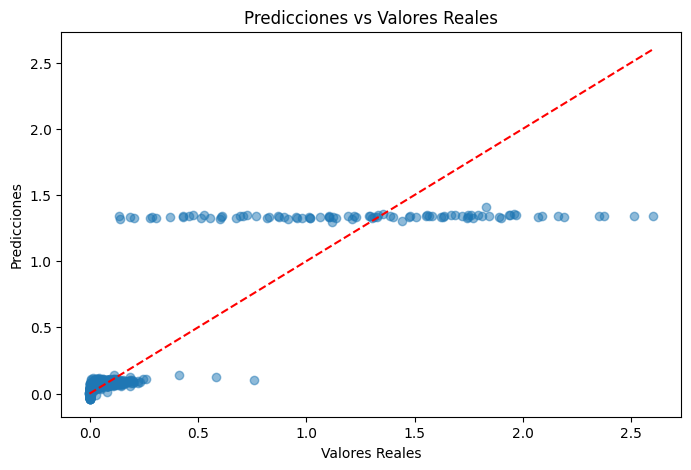

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea ideal
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.show()


El modelo de regresión predice bien valores bajos de redshift, pero presenta un sesgo al no capturar adecuadamente valores más altos, ya que muchas predicciones se agrupan en torno a 1.5 sin seguir la tendencia esperada. Esto sugiere que el modelo es demasiado simple o que las variables utilizadas no explican bien la variabilidad del redshift.

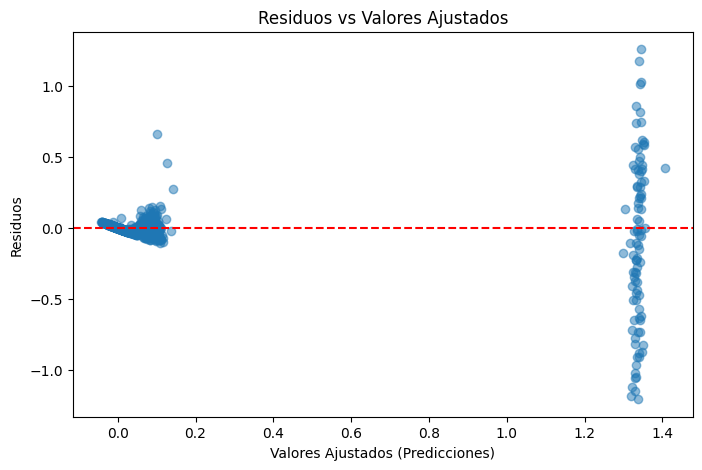

In [ ]:
residuos = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Ajustados (Predicciones)")
plt.ylabel("Residuos")
plt.title("Residuos vs Valores Ajustados")
plt.show()


Los residuos no están distribuidos aleatoriamente en torno a la línea roja de referencia (cero), sino que hay dos agrupaciones: una muy concentrada cerca de valores ajustados bajos y otra cerca de 1.4. El modelo no está capturando correctamente la variabilidad de los datos (lo explicamos al validar los supuestos).

# PARTE 7 -> EXPORTAR Pipeline
El pipeline implementado transforma los datos mediante la conversión logarítmica de u y la codificación de la variable categórica class, asegurando un adecuado preprocesamiento. Luego, selecciona un las variables, incluyendo magnitudes, variables de posición y clases categóricas codificadas. A continuación, aplica StandardScaler para la normalización y entrena un modelo de regresión lineal para predecir redshift. Finalmente, el pipeline entrenado se exporta en formato .joblib.

In [ ]:
trainData["u_log2"] = np.log2(trainData["u"])
trainData["class"] = trainData["class"].replace({"QUASAR": "QSO", "S": "STAR", "G": "GALAXY"})
trainData_encoded = pd.get_dummies(trainData, columns=["class"], drop_first=True)

features2 = ["u_log2", "g", "r", "i", "z", "rowv", "colv", "class_QSO", "class_STAR"]
X = trainData_encoded[features2]
y = trainData_encoded["redshift"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Definición del pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline.fit(X_train, y_train)

coef_df = pd.DataFrame({"columns": features2, "coef": pipeline["model"].coef_})
print(coef_df)

joblib.dump(pipeline, "linear_regression_pipeline.joblib")
print("Pipeline guardado en 'linear_regression_pipeline.joblib'.")
pipeline


      columns      coef
0      u_log2  0.004743
1           g -0.020548
2           r  0.038557
3           i  0.007062
4           z -0.012238
5        rowv -0.006720
6        colv  0.003435
7   class_QSO  0.315559
8  class_STAR -0.041048
Pipeline guardado en 'linear_regression_pipeline.joblib'.


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
pipeline = joblib.load("linear_regression_pipeline.joblib")
print("Pipeline cargado exitosamente.")

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar resultados
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

Pipeline cargado exitosamente.
MAE: 0.0593
MSE: 0.0290
R²: 0.7819
RMSE: 0.1702


# PARTE 8 -> Archivo de predicción

In [ ]:
def process_and_predict(testData):
    # Cargar el pipeline
    pipeline = joblib.load("linear_regression_pipeline.joblib")
    print("Pipeline cargado exitosamente.")

    testData["u_log2"] = np.log2(testData["u"])
    testData["class"] = testData["class"].replace({"QUASAR": "QSO", "S": "STAR", "G": "GALAXY"})
    testData["class"] = testData["class"].replace("QUASAR", "QSO")
    testData["class"] = testData["class"].replace("S", "STAR")
    testData["class"] = testData["class"].replace("G", "GALAXY")
    testData_encoded = pd.get_dummies(testData, columns=["class"], drop_first=True)

    features2 = ["u_log2", "g", "r", "i", "z", "rowv", "colv", "class_QSO", "class_STAR"]
    for col in features2:
        if col not in testData_encoded:
            raise ValueError(f"La columna '{col}' no está presente en el conjunto de datos de prueba.")

    X_test = testData_encoded[features2]

    testData["redshift_predicted"] = pipeline.predict(X_test)

    testData.to_csv("predictions_redshift.csv", index=False)
    print("Predicciones guardadas en 'predictions_redshift.csv'.")

    return testData

testData = gestTestData()
testData = process_and_predict(testData)
testData.describe()

Pipeline cargado exitosamente.
Predicciones guardadas en 'predictions_redshift.csv'.


,ra,colv,i,rowv,dec,score,camcol,field,clean,r,z,g,run,objid,u,mjd,u_log2,redshift_predicted
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,184.950251,-0.000277,16.638152,0.000681,0.320340,0.848917,3.414000,422.103000,0.905000,16.881443,16.476512,17.399080,743.185000,1.237649e+18,18.644022,52980.451000,4.219249,0.158453
std,43.668487,0.015001,1.124757,0.014393,2.154713,0.081818,1.703381,170.831589,0.293362,1.061083,1.189690,0.925944,104.629136,4.491708e+11,0.803800,1646.460261,0.064046,0.375543
min,10.573414,-0.436981,13.189270,-0.059088,-1.251747,0.301912,1.000000,19.000000,0.000000,13.601880,12.874640,14.207690,211.000000,1.237646e+18,15.222080,51608.000000,3.928094,-0.440287
25%,162.746847,-0.001571,15.891723,-0.001184,-0.586940,0.837106,2.000000,313.000000,1.000000,16.235055,15.650908,16.872863,752.000000,1.237649e+18,18.257548,51691.000000,4.190421,0.003552
50%,194.750021,-0.000007,16.613260,0.000309,0.072233,0.860989,3.000000,443.000000,1.000000,16.893035,16.452875,17.500865,756.000000,1.237649e+18,18.877740,51985.000000,4.238614,0.058666
75%,215.741906,0.001616,17.331238,0.001736,0.642781,0.879400,5.000000,528.250000,1.000000,17.560005,17.203720,18.024877,756.000000,1.237649e+18,19.259638,54468.000000,4.267509,0.087395
max,249.797565,0.095321,24.363100,0.415764,13.870977,0.961145,6.000000,812.000000,1.000000,24.805700,22.828710,21.368050,1035.000000,1.237650e+18,19.598260,58932.000000,4.292654,1.368763
